# Store sale prediction - Curso Meigaron

# 0.0 CONFIGURAÇÕES INICIAIS

### Utilidades

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Para não desconectar:
'''
var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End"); 
    };

    var intervalId = setInterval(clickConnect, 1800000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();

#In order to stop, call:

stopClickConnect();


#pode ser também: 
function ClickConnect(){

console.log("Working"); 
document.querySelector("#comments > span").click() 
}
setInterval(ClickConnect,1800000)
'''

In [ ]:
#pip install 

### 0.1. Git

In [3]:
!git init

Reinitialized existing Git repository in /content/.git/


In [4]:
!git config --global user.email henriquelucasdf@gmail.com
!git config --global user.name henriquelucasdf

In [5]:
cd /content/drive/My Drive/data_science/repos/

/content/drive/My Drive/data_science/repos


In [8]:
cd Previsao_vendas_rossmann/

/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann


In [10]:
!git clone https://github.com/henriquelucasdf/Previsao_vendas_rossmann.git 

Cloning into 'Previsao_vendas_rossmann'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [12]:
!git init

Initialized empty Git repository in /content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/.git/


In [ ]:
!git commit -m 'deployed in heroku'

[main 84cdd4f] deployed in heroku
 11 files changed, 4 insertions(+), 7 deletions(-)
 rewrite Store_Sale_Prediction.ipynb (75%)
 rename Procfile => webapp/Procfile (100%)
 rename handler.py => webapp/handler.py (81%)
 rename {model => webapp/model}/model_xgb_tuned.pkl (100%)
 rename {parameter => webapp/parameter}/competition_distance_scaler.pkl (100%)
 rename {parameter => webapp/parameter}/competition_time_month_scaler.pkl (100%)
 rename {parameter => webapp/parameter}/promo_time_week_scaler.pkl (100%)
 rename {parameter => webapp/parameter}/store_type_scaler.pkl (100%)
 rename {parameter => webapp/parameter}/year_scaler.pkl (100%)
 rename requirements.txt => webapp/requirements.txt (100%)
 rename {rossmann => webapp/rossmann}/Rossmann.py (100%)


In [ ]:
!git push origin main

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 3.83 KiB | 68.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/henriquelucasdf/Predict-Time-Series-Test.git
   6a4c6ce..84cdd4f  main -> main


In [ ]:
# Apagar um commit no github
#!git reset --hard cd06c87e977d4b2a8eb8ac1c8e56ca25d462f663
#!git push -f origin main

HEAD is now at cd06c87 Teste do deploy do modelo em Flask
Total 0 (delta 0), reused 0 (delta 0)
^C


### 0.2. IMPORTS

In [ ]:
!pip install inflection
!pip install dython
!pip install boruta

     |████████████████████████████████| 61kB 1.8MB/s 


In [ ]:
import pandas as pd
import inflection #Inflection is a string transformation library
import math
import numpy as np
import datetime
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import display, HTML
from tabulate import tabulate
from scipy import stats
from dython.nominal import associations #correlação entre variáveis categóricas

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.model_selection import TimeSeriesSplit

from boruta import BorutaPy
import xgboost as xgb

### 0.3. Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set() 
    
jupyter_settings()

def mean_absolute_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean((y - yhat) / y)

def Symmetric_Mean_Absolute_Percentage_Error(y: np.ndarray, yhat: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return np.mean(2.0 * np.abs(y - yhat) / ((np.abs(y) + np.abs(yhat)) + EPSILON))

def ml_error (model_name, y, yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat) 
  rmse = np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame({ 'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index = [0])


def TimeSeries_cross_validation(x_training, kfold, model_name, model, verbose=True):
  ''' Insira o X_train com 'Date' e o 'Target'.
      Retorna um dataframe com a média e o desvio padrão dos Kfolds '''

  mae_list=[]
  mape_list=[]
  rmse_list=[]
  for k in reversed(range(1, (kfold+1))):
  # start and end date for validation 
    validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

     # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
    xtraining = training.drop( ['date', 'sales'], axis=1 ) 
    ytraining = training['sales']

        # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

        # model
    m = model.fit( xtraining, ytraining )

        # prediction
    yhat = m.predict( xvalidation )

        # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
    mae_list.append(  m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

        #Print
    if verbose==True:
      print('\nKfold_number: {}'.format(k))
      print('MAE = {}'.format(m_result['MAE'][0]))
      print('MAPE = {}'.format(m_result['MAPE'][0]))
      print('RMSE = {}'.format(m_result['RMSE'][0]))

  return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 0.4. Loading Data

In [ ]:
df_sales_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Dados/train.csv',low_memory = False)
df_store_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Dados/store.csv',low_memory = False)

#Fazendo o Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how ='left', on = 'Store')

In [ ]:
#Pegando uma linha aleatória p/ verificar o merge:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
661754,230,5,2013-11-15,6298,855,1,0,0,0,d,c,6680.0,9.0,2013.0,0,NaN,NaN,NaN


---
# 1.0 DESCRIÇÃO DOS DADOS

### 1.1. Rename Columns

In [ ]:
#Copiar uma cópia do dataset para economizar tempo
df1 = df_raw.copy()

In [ ]:
# Renomeando as colunas
cols_old = [col for col in df1.columns]
#Usando snakecase da biblioteca inflection:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#Renomeando: 
df1.columns = cols_new


### 1.2. Data Dimensions

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Data Types

In [ ]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [ ]:
#Transformando a coluna date para o tipo datetime:
df1['date'] = pd.to_datetime(df1['date'])

### 1.4. Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [ ]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
112732,118,2,2015-04-21,5413,516,1,0,0,0,d,c,3580.0,9.0,2012.0,0,NaN,NaN,NaN
794200,1106,6,2013-07-20,2664,340,1,0,0,0,a,c,5330.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
151508,984,3,2015-03-18,6975,769,1,1,0,0,c,a,440.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
400875,1039,3,2014-07-09,7346,910,1,0,0,1,a,c,70.0,6.0,1990.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
962077,618,2,2013-02-19,4469,321,1,1,0,0,d,c,9910.0,NaN,NaN,0,NaN,NaN,NaN


### 1.5. Fillout NA

In [ ]:
#competition_distance: É NA provavelmente porque não existe competidor próximo
# valor máximo:
df1.competition_distance.max() #75860 
#Se for NA substituir por um valor absurdamente alto
df1.competition_distance = df1.competition_distance.apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month : se for NA, substituir pela Data do NA. Apenas como primeira interação (tentativa)
#Obs: quando o Apply é aplicado em mais de uma coluna, é necessário indicar o eixo = 1
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year     
df1.competition_open_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year , axis = 1)
                              
#promo2_since_week            
df1.promo2_since_week = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis = 1)

#promo2_since_year    
df1.promo2_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis = 1)

#promo_interval: se não participar da promoção, colocar 0. Se participar, criar uma nova coluna indicando se está tendo uma promoção na data da linha   
months_dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11:'Nov', 12: 'Dec'}
df1.promo_interval.fillna(0, inplace = True)
df1['month_map'] = df1.date.dt.month.map(months_dic)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x.promo_interval == 0 else 1 if x.month_map in x.promo_interval.split(',') else 0,axis = 1)

### 1.6. Change Types

In [ ]:
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)

df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

#### 1.7.1. Descriptive Statistical

##### 2 métricas mais importantes: medidas de dispersão e de medida central

##### Deve-se separar as colunas categóricas e as numéricas

In [ ]:
num_attributes = df1.select_dtypes(include=['int64','int32','float64','float32'])
cat_attributes = df1.select_dtypes(exclude=['int64','int32','float64','float32','datetime64[ns]'])

#### 1.7.2. Numerical Attributes

In [ ]:
#Central Tendency - mean, median
#Variáveis numéricas:
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T #.T = transposto
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersão - std,min,max, range, skew, kurtosis
#num_attributes.describe() >>> Fica na notação científica. Ruim!
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,ct_mean,ct_median,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m            

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.3. Categorical Attributes

In [ ]:
#Visualizando valores únicos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

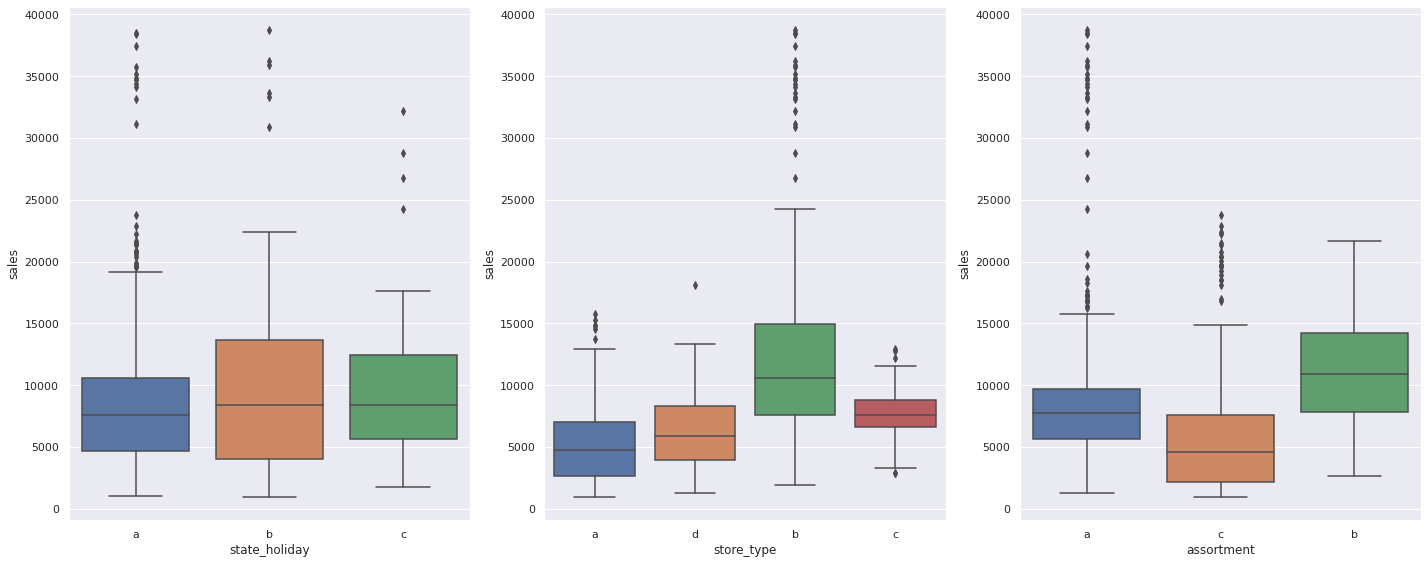

In [ ]:
#Fazendo um boxplot
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data=aux1)
plt.tight_layout()

---

# 2.0. FEATURE ENGINEERING

### 2.1 Mapa mental de hipóteses

In [ ]:
df2 = df1.copy()

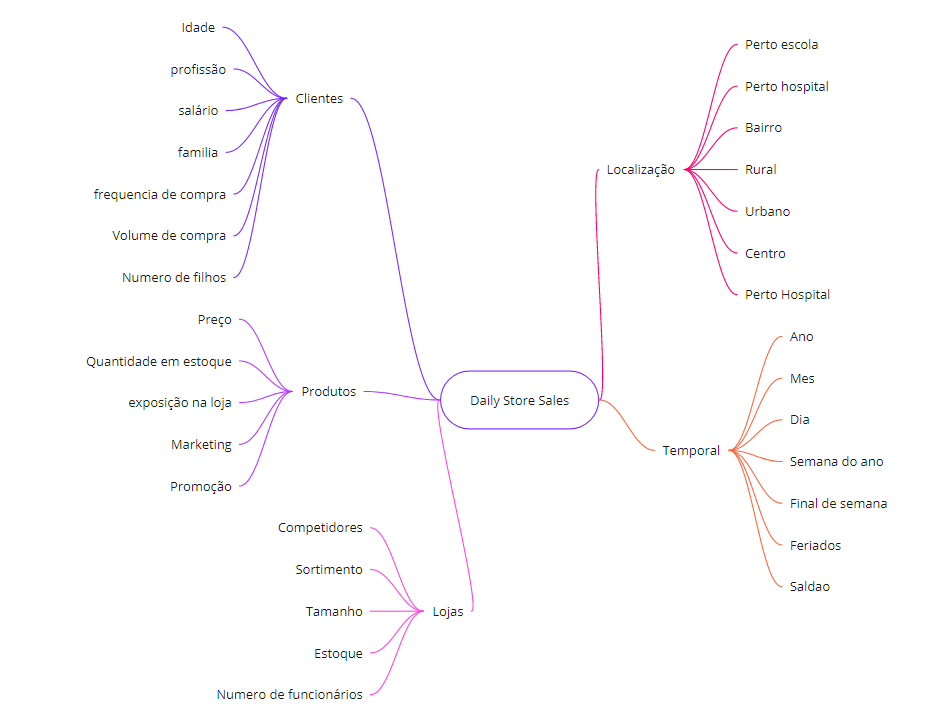

In [ ]:
Image('Imagens/mind_map_hyphotesis.png')

### 2.2 Criação de hipóteses

#### 2.2.1. Hipóteses Loja
**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais. 

#### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos na vitrine deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais. 

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada ano.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Hipóteses finais - Critério: disponibilidade de dados.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais. 

**4.** Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais. 

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada ano.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.4 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2.date.dt.month
#day
df2['day'] = df2.date.dt.day
#week of year
df2['week_of_year'] = df2.date.dt.weekofyear
#year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
#competition since - tempo desde que a competição começou - Está separada em 2 colunas, precisamos uni-las
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since - tempo desde que a promoção começou
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2.date - df2.promo_since)/7).apply(lambda x: x.days).astype(int)

In [ ]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 2.5. FILTRAGEM DE VARIÁVEIS

In [ ]:
df3 = df2.copy()

#### 2.5.1. Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]
df3[df3['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week


#### 2.5.2. Seleção das colunas

In [ ]:
cols_drop=['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

---

---
# 3.0. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [ ]:
df4 = df3.copy()
num_attributes2 = df4.select_dtypes(include=['int64','int32','float64','float32'])
cat_attributes2 = df4.select_dtypes(exclude=['int64','int32','float64','float32','datetime64[ns]'])

### 3.1. Análise Univariada

##### 3.1.1 Response Variable

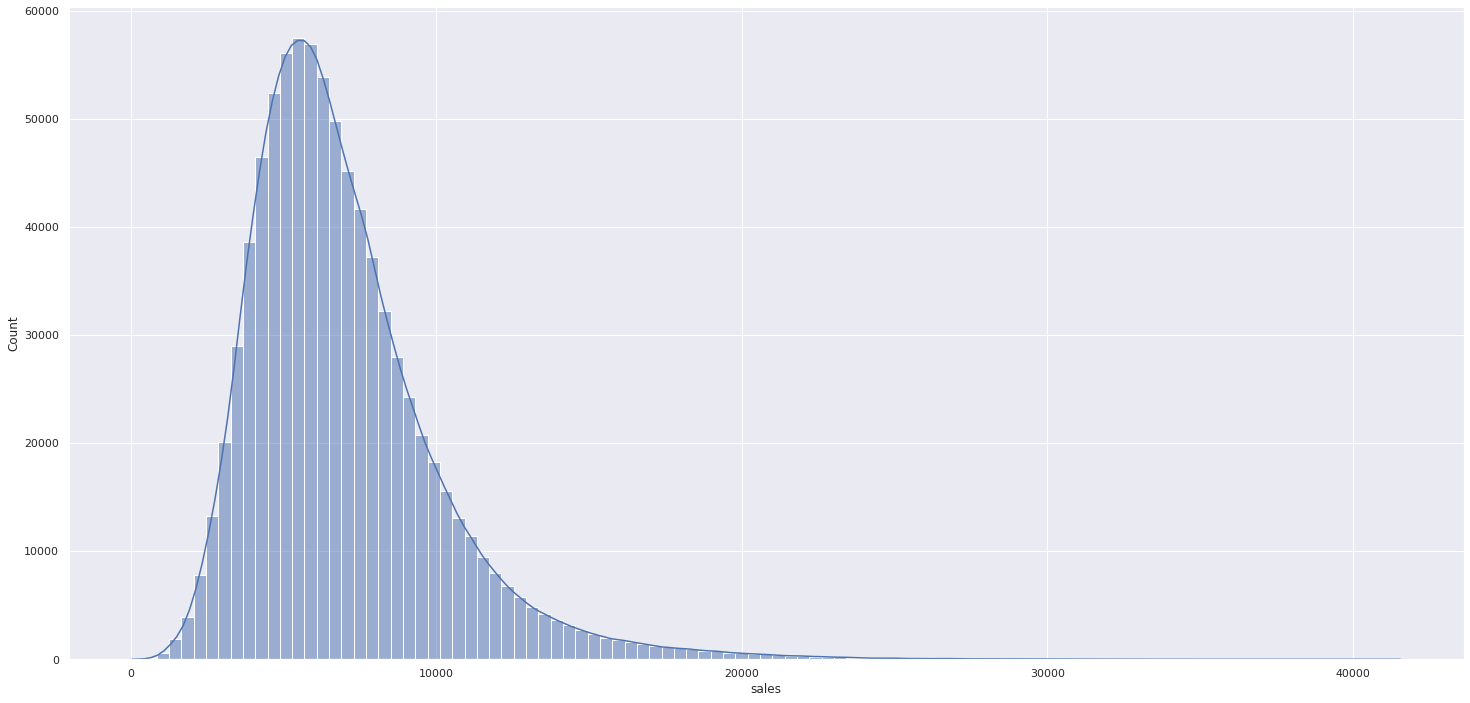

In [ ]:
#@title Histograma: Sales
sns.histplot(df4.sales, kde=True, bins= int((df4.sales.max()-df4.sales.min())/400))

##### 3.1.2 Numerical Variable

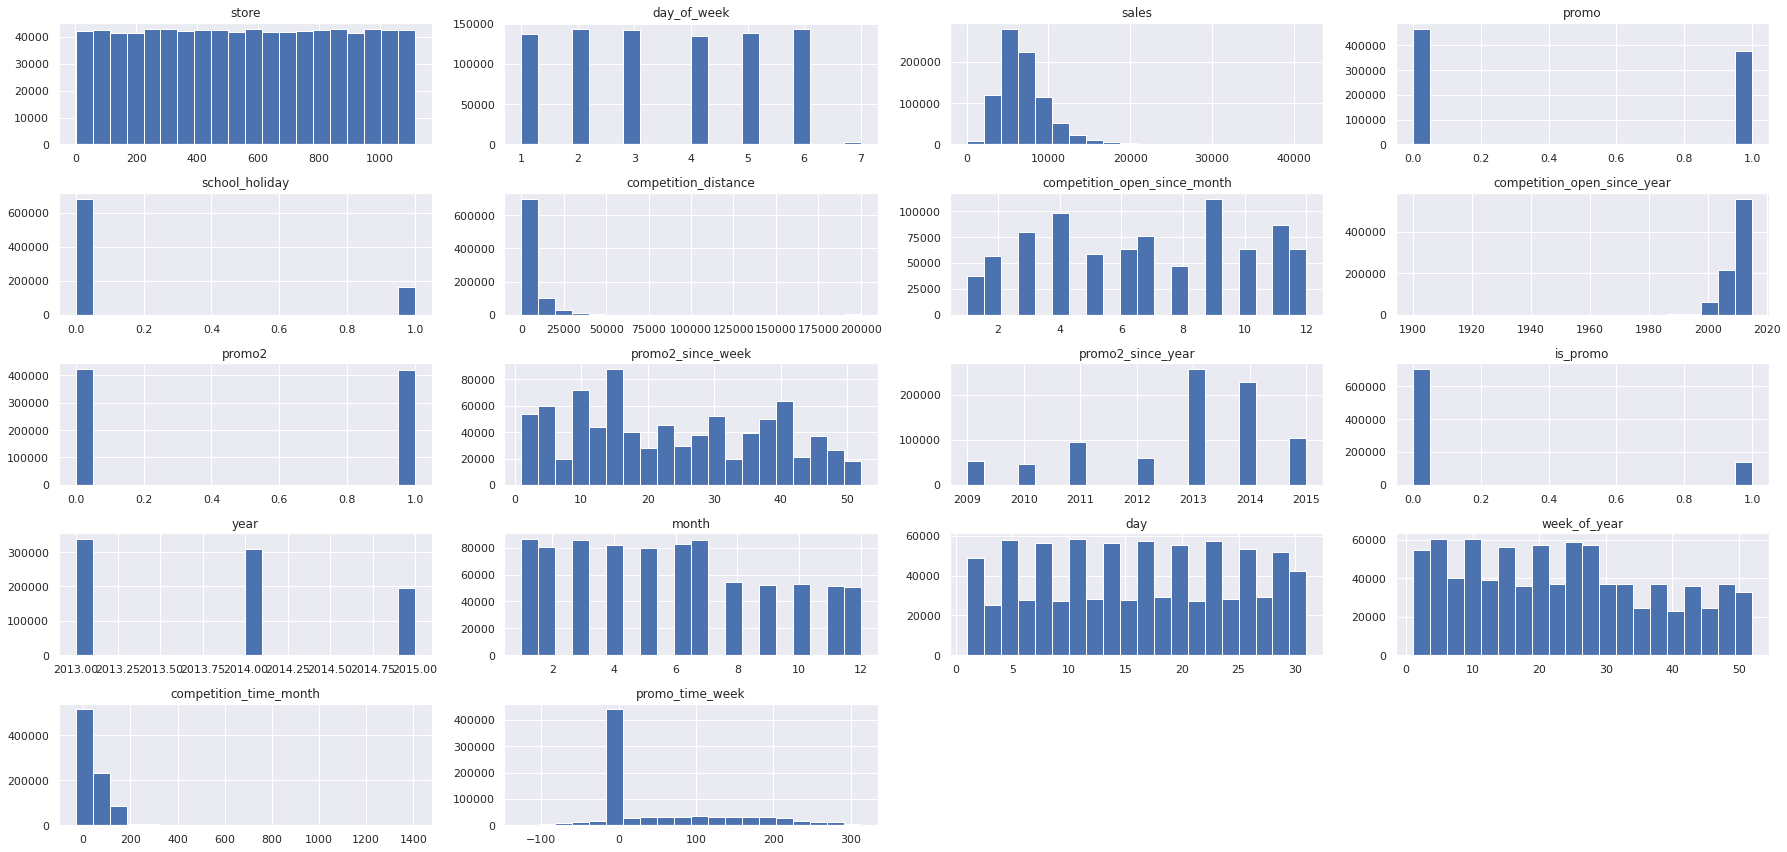

In [ ]:
#@title Gráficos das variáveis numéricas
num_attributes2.hist(bins=20);
plt.tight_layout()

##### 3.1.3 Categorical Variable

In [ ]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


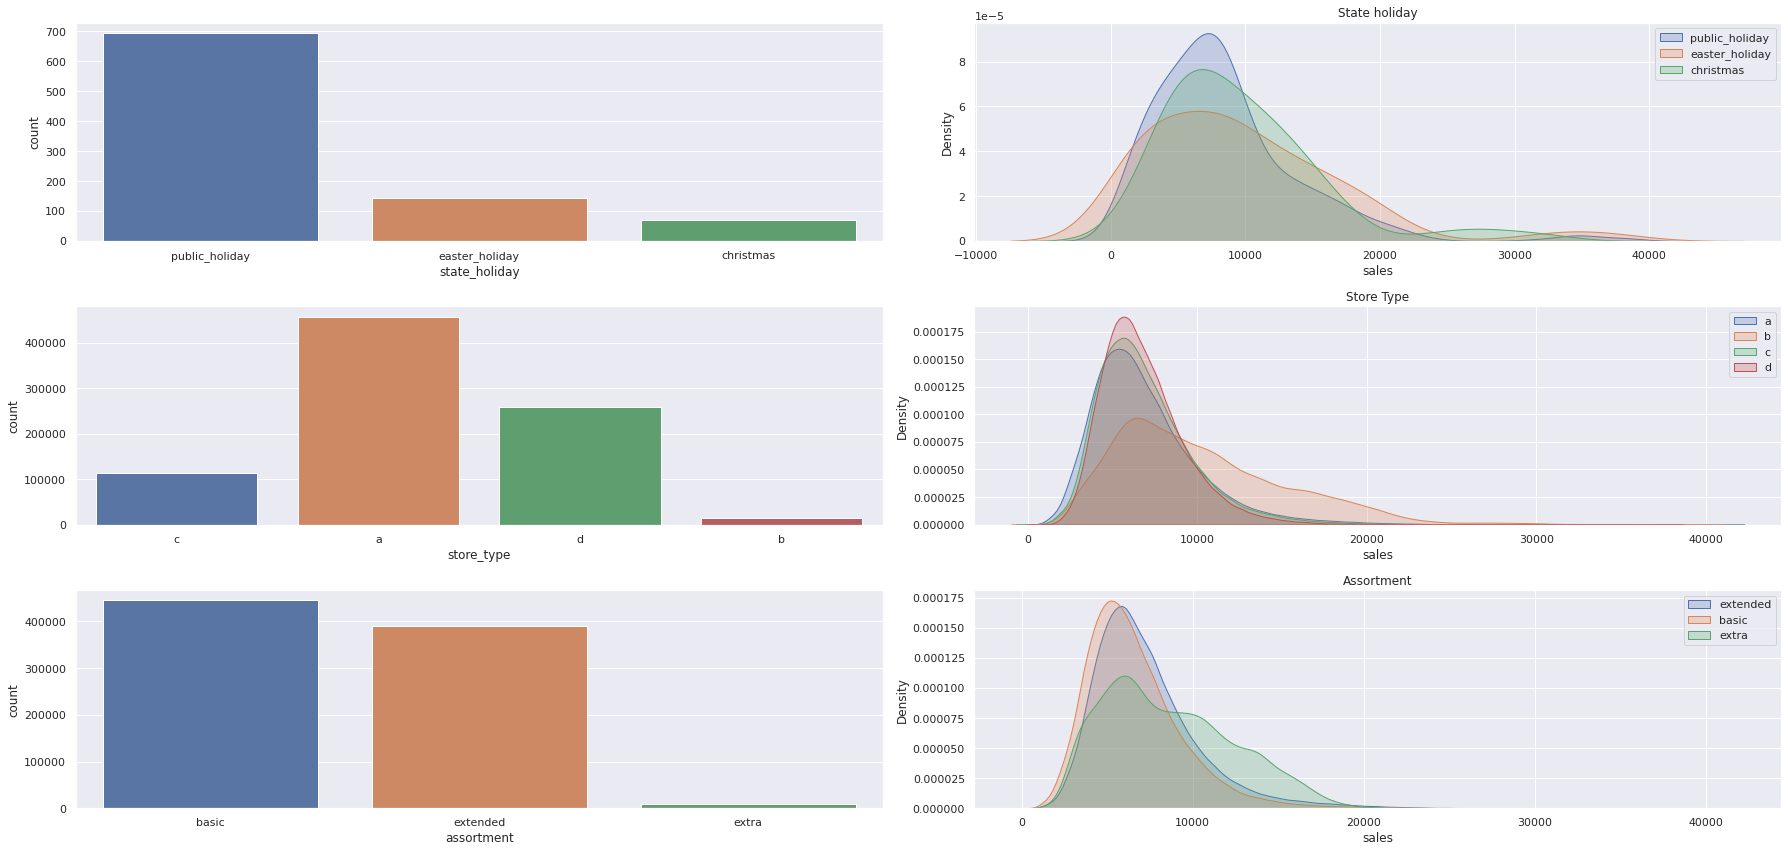

In [ ]:
#@title Gráficos das variáveis categóricas

#state_holiday
plt.subplot(3,2,1);
a = df4[df4['state_holiday']!= 'regular_day'];
sns. countplot(a['state_holiday']);

plt.subplot(3,2,2);
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],shade=True );
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], shade=True);
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], shade=True);
plt.legend( ('public_holiday','easter_holiday','christmas'),  loc='upper right');
plt.title('State holiday')
#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],shade=True );
sns.kdeplot(df4[df4['store_type']=='b']['sales'], shade=True);
sns.kdeplot(df4[df4['store_type']=='c']['sales'], shade=True);
sns.kdeplot(df4[df4['store_type']=='d']['sales'], shade=True);
plt.title('Store Type')
plt.legend( ('a','b','c','d'),  loc='upper right');

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],shade=True );
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], shade=True);
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], shade=True);
plt.title('Assortment')
plt.legend( ('extended','basic','extra'),  loc='upper right');

plt.tight_layout()

### 3.2. Análise Bivariada

#### H1. Lojas com maior sortimento deveriam vender mais.



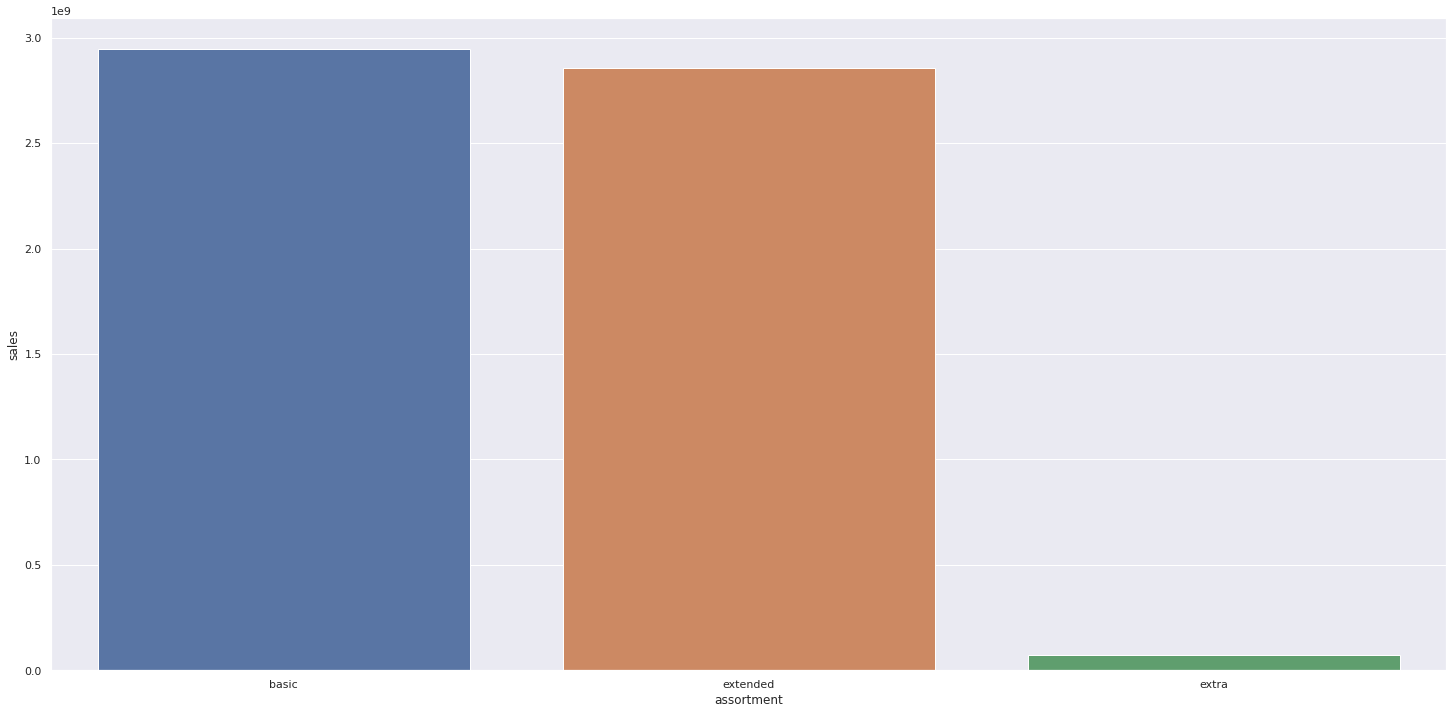

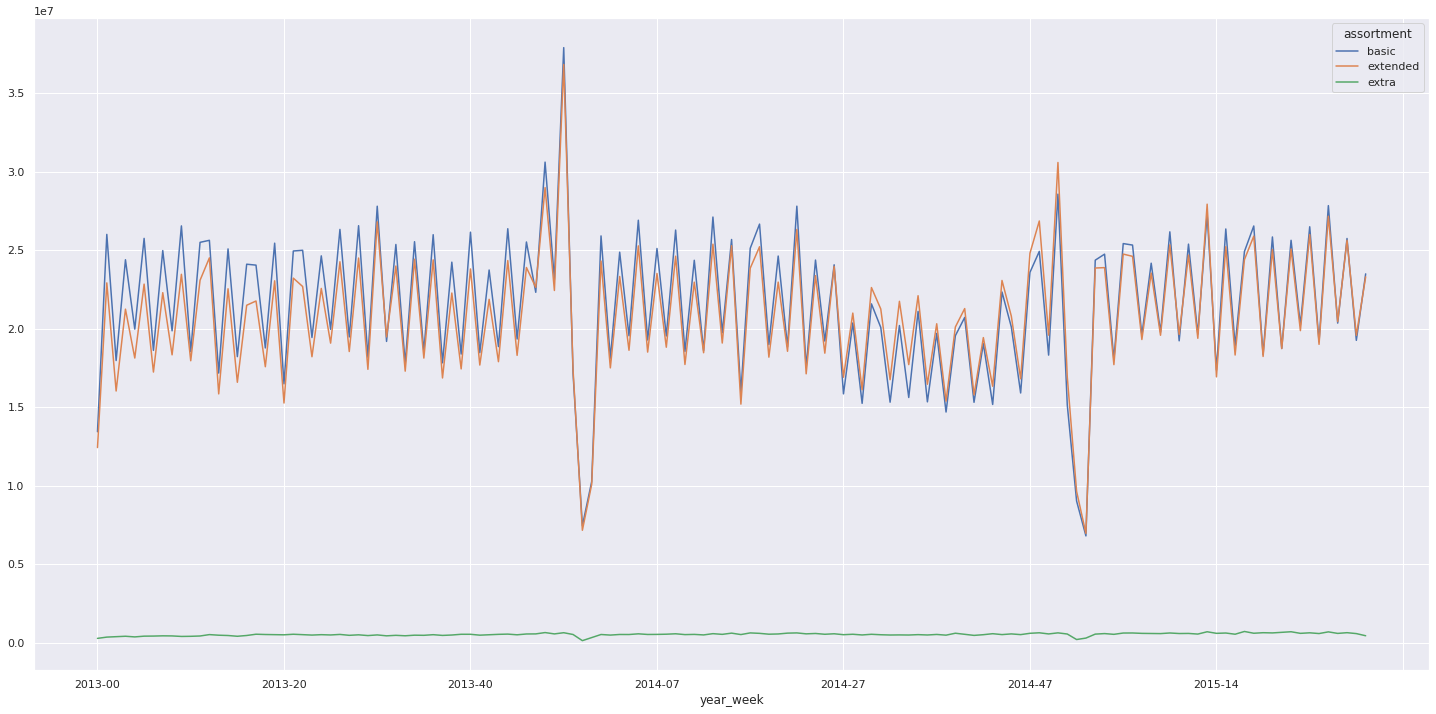

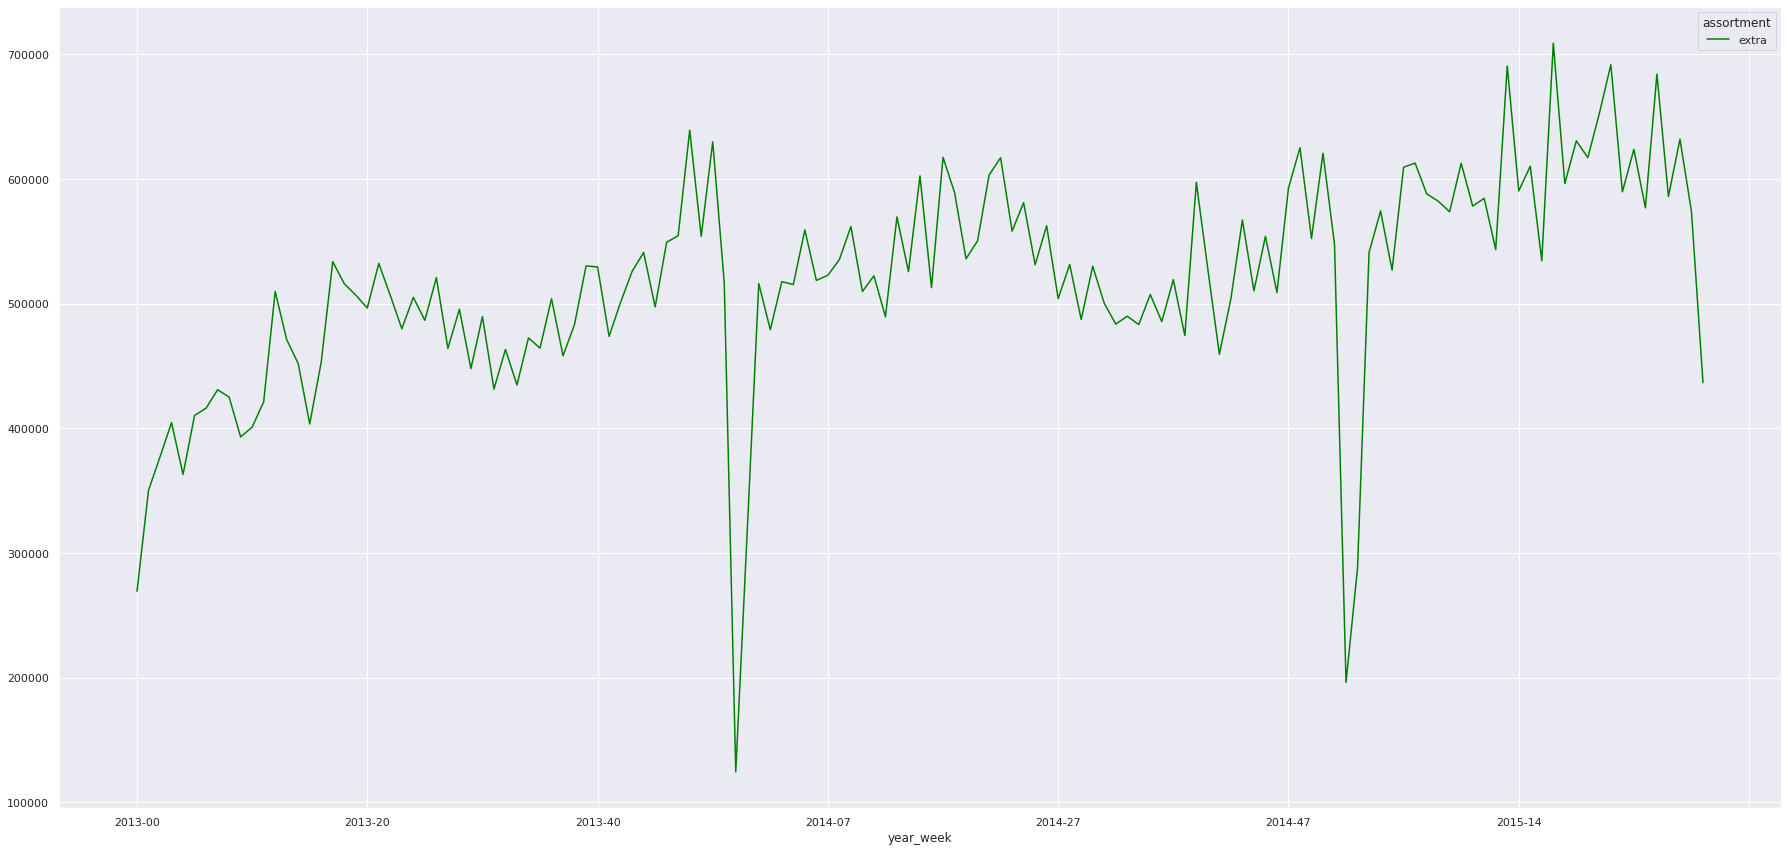

In [ ]:
#@title FALSA. Na verdade, lojas com maior sortimento vendem menos
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment',values='sales').plot()      

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',values='sales').plot(color = 'green')      

plt.tight_layout()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

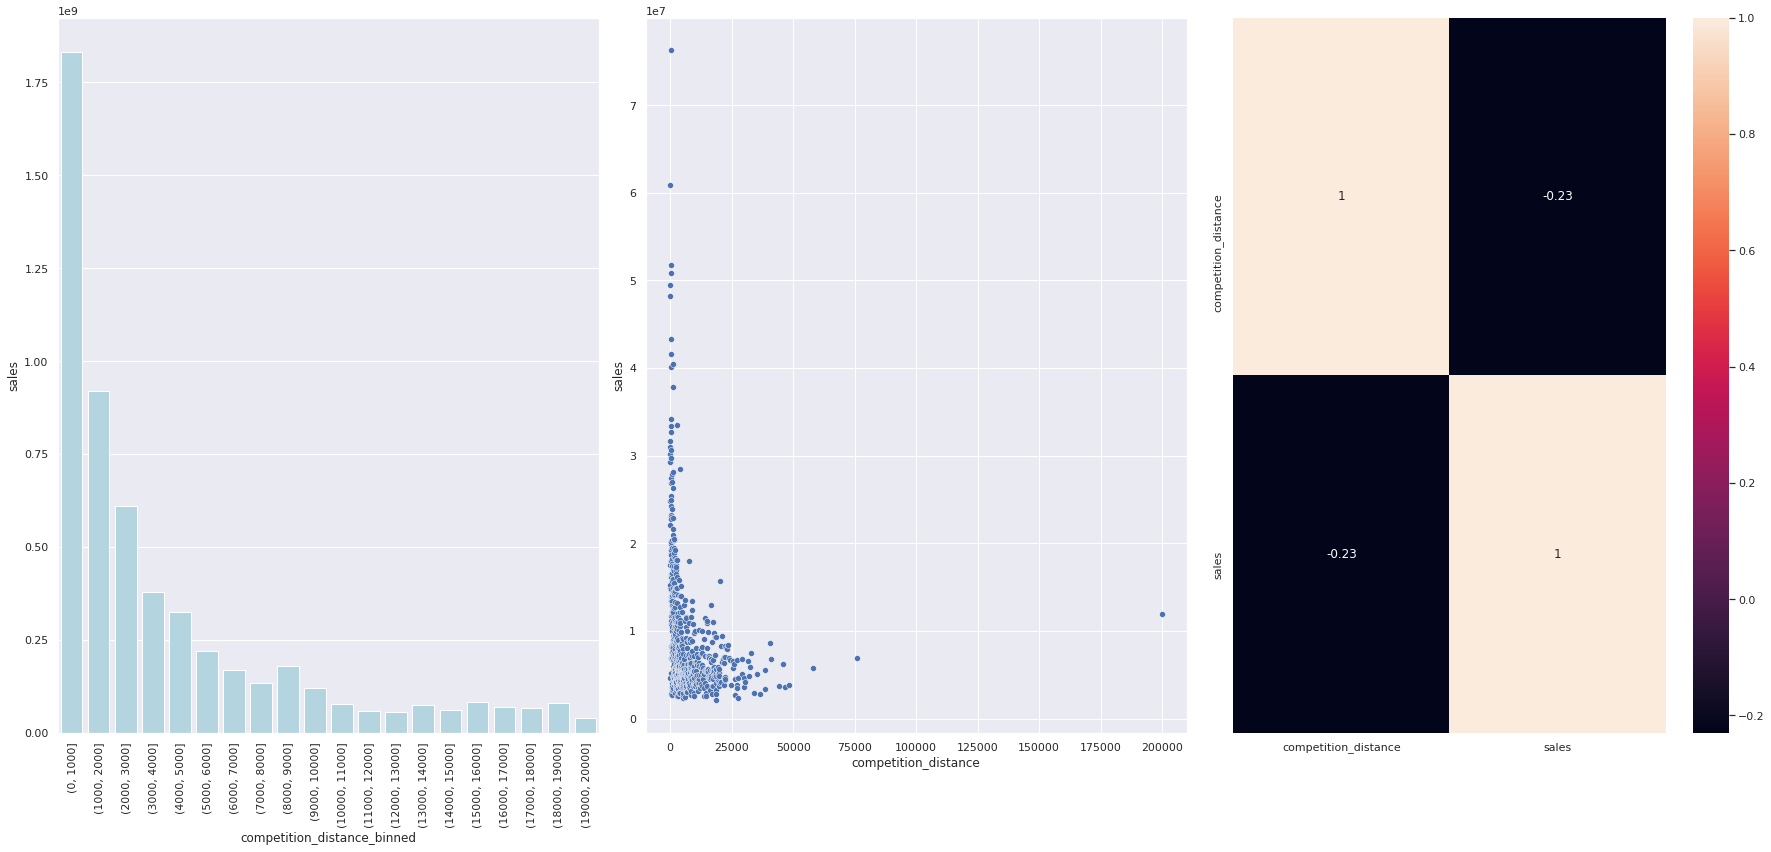

In [ ]:
#@title Falsa! Lojas com competidores mais próximos vendem mais.
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance',).sum().reset_index()
#Poderia ser um scatterplot, mas vamos fazer com grafico de barras
# Vamos colocar os valores de competition_distance em classes
bins = list(range(0,21000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins) #Use cut when you need to segment and sort data values into bins. 

aux2 =  aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned',).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'competition_distance_binned', y='sales',data = aux2, color='lightblue') #Eixo ficou ruim-Rotacionar!
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1 )
#medindo a correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.tight_layout()



#### H3. Lojas com competidores a mais tempo deveriam vender mais.

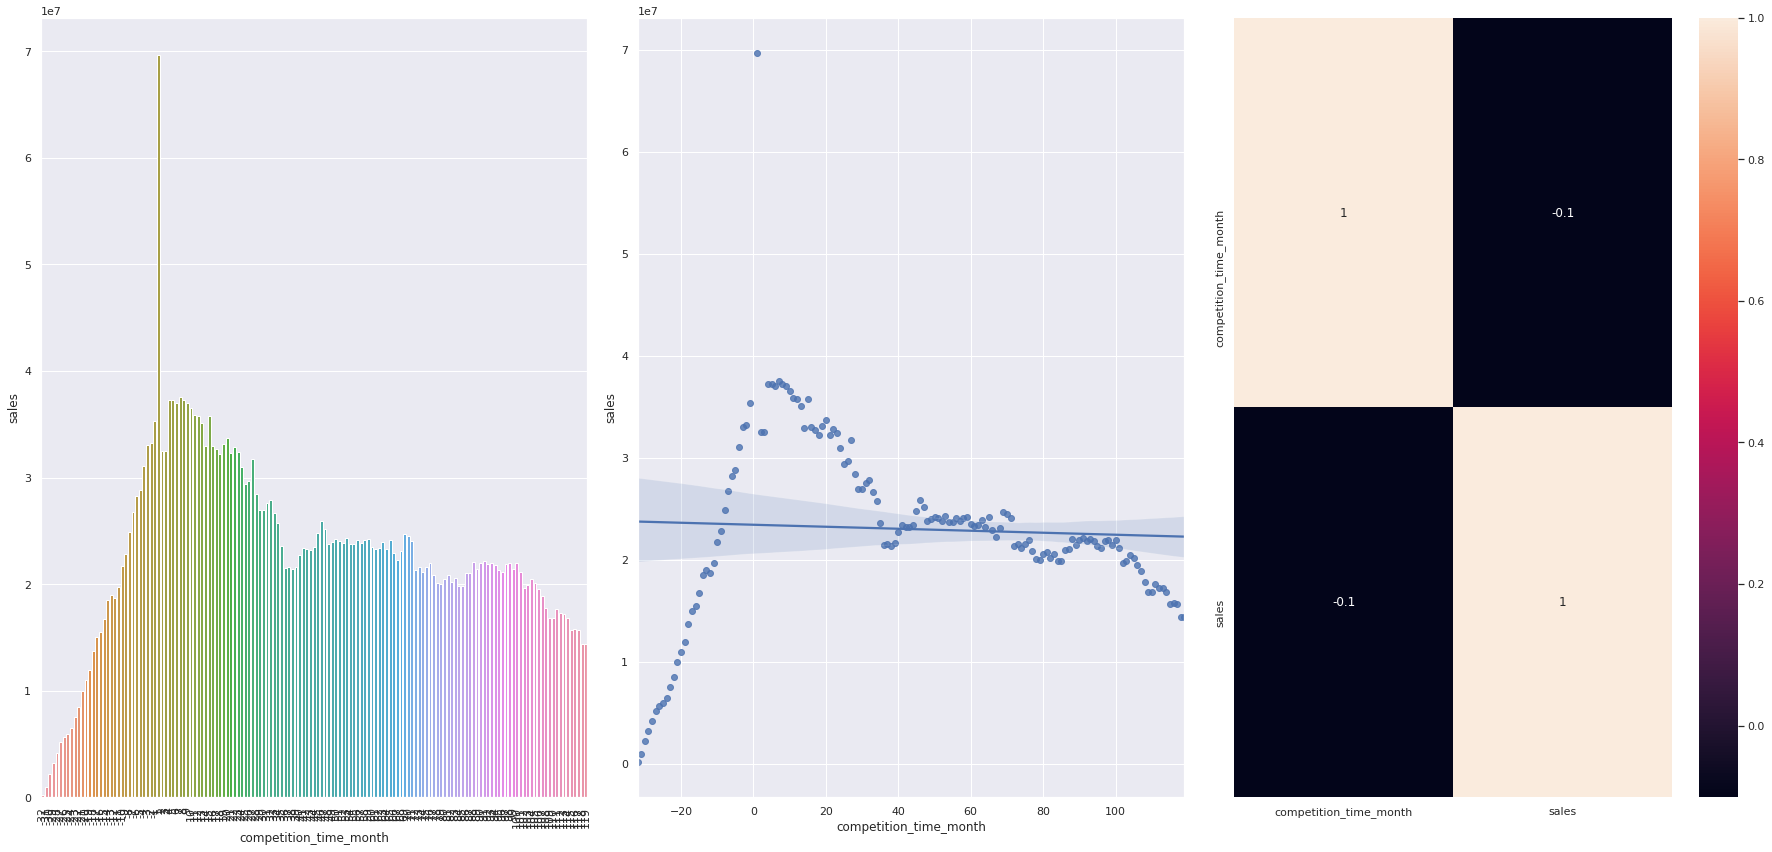

In [ ]:
#@title **Falsa!** Lojas com competidores a mais tempo vendem menos!

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] !=0 )]

plt.subplot(1,3,1)
sns.barplot(x= 'competition_time_month',y='sales',data = aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month',y='sales',data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.tight_layout()

#### H4. Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais.

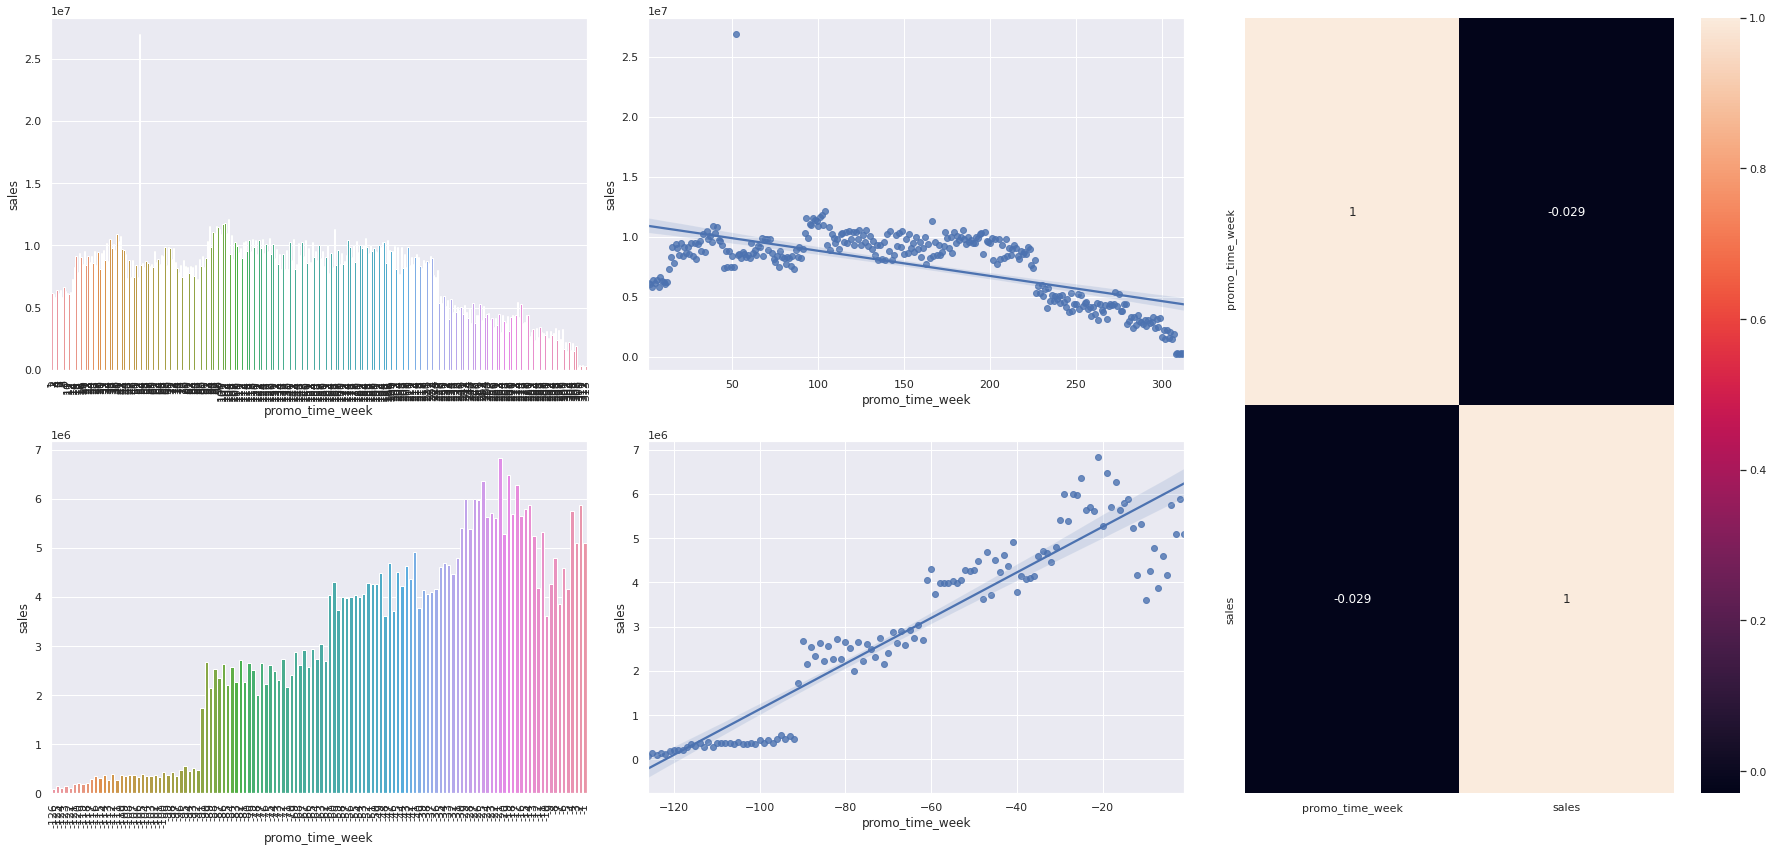

In [ ]:
#@title **Falsa!** As vendas decaem após certo período de promoção. 

aux1=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promoção extendida
sns.barplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promoção regular
sns.barplot(x='promo_time_week', y='sales',data=aux3);
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.tight_layout()

#### H5. Lojas com mais dias de promoção deveriam vender mais
- Validar no segundo ciclo do CRISP

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.

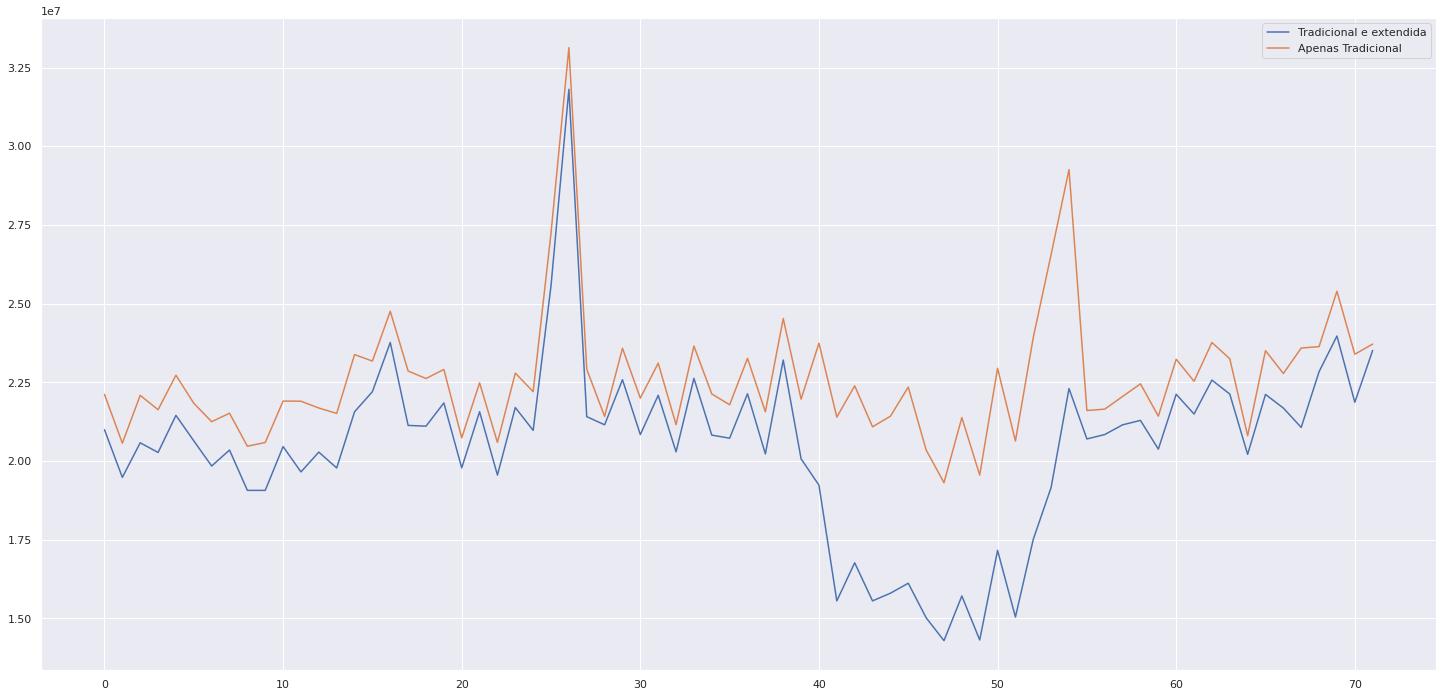

In [ ]:
#@title **Falsa!**, lojas que participaram apenas da promo1 venderam mais.
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

#Vendo o comportamento ao longo do tempo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional e extendida', 'Apenas Tradicional'])

#### H7. Lojas abertas durante o Natal deveriam vender mais.


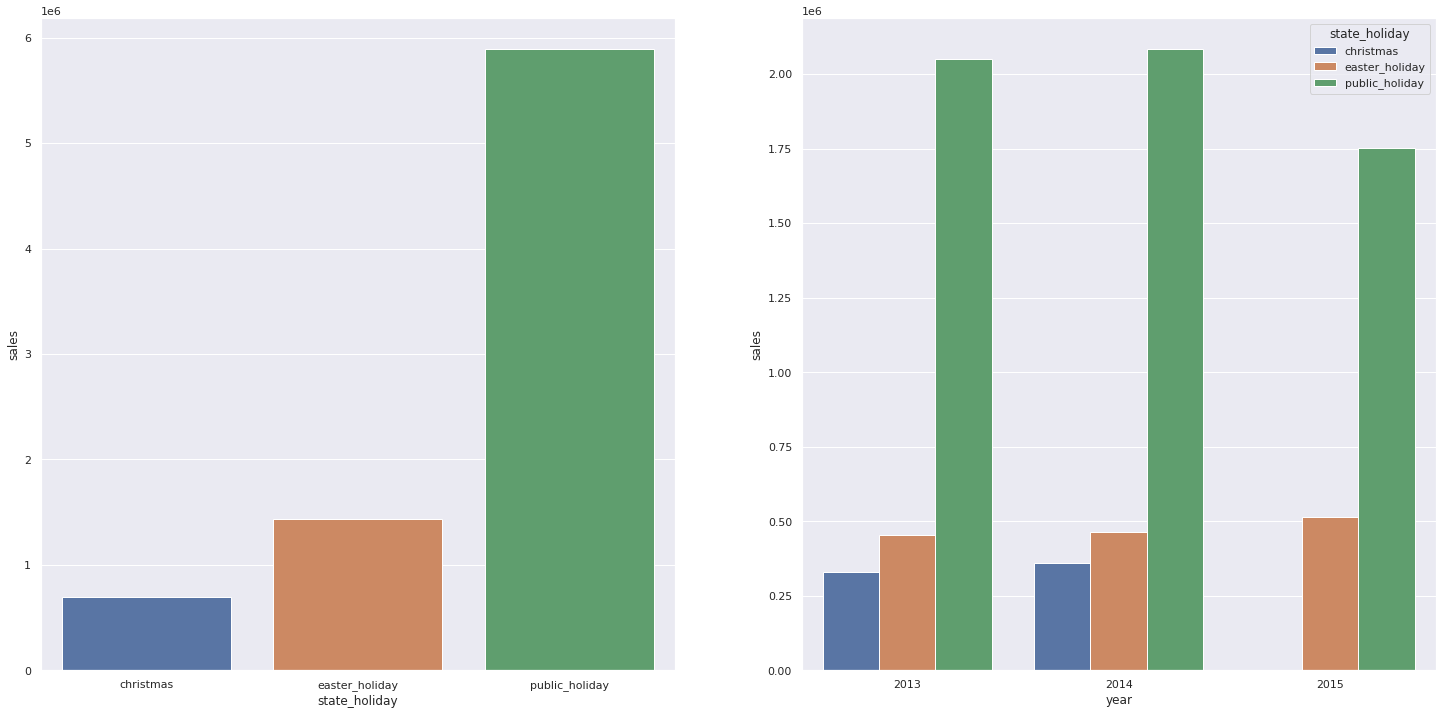

In [ ]:
#@title **Falsa!** Lojas vendem menos durante o natal
aux = df4[df4['state_holiday']!='regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales',data=aux1);
plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',data=aux2, hue='state_holiday' );

#### H8. Lojas deveriam vender mais ao longo dos anos.

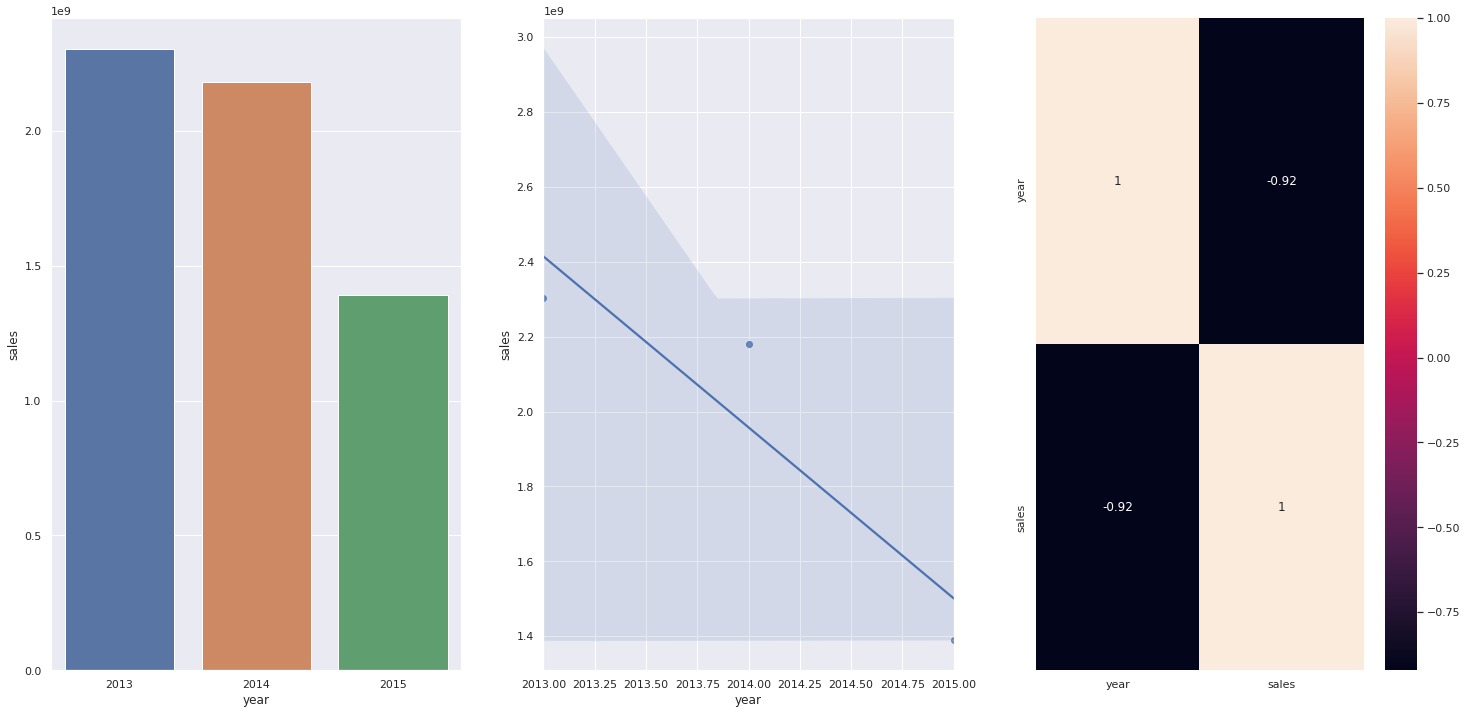

In [ ]:
#@title **Falsa!** As vendas estão caindo.
#obs: 2015 não está completo!
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H9. Lojas deveriam vender mais no segundo semestre do ano.

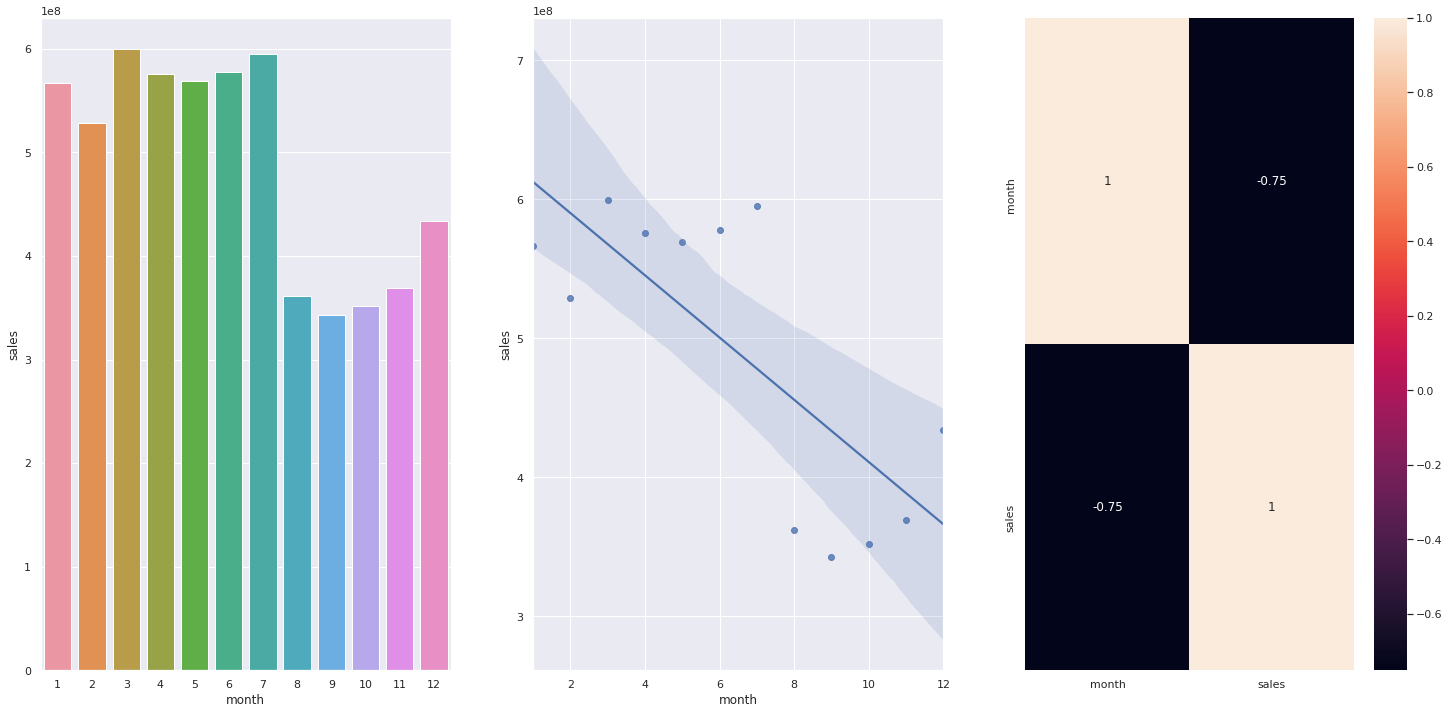

In [ ]:
#@title **Falsa!** Lojas vendem menos no segundo semestre.
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

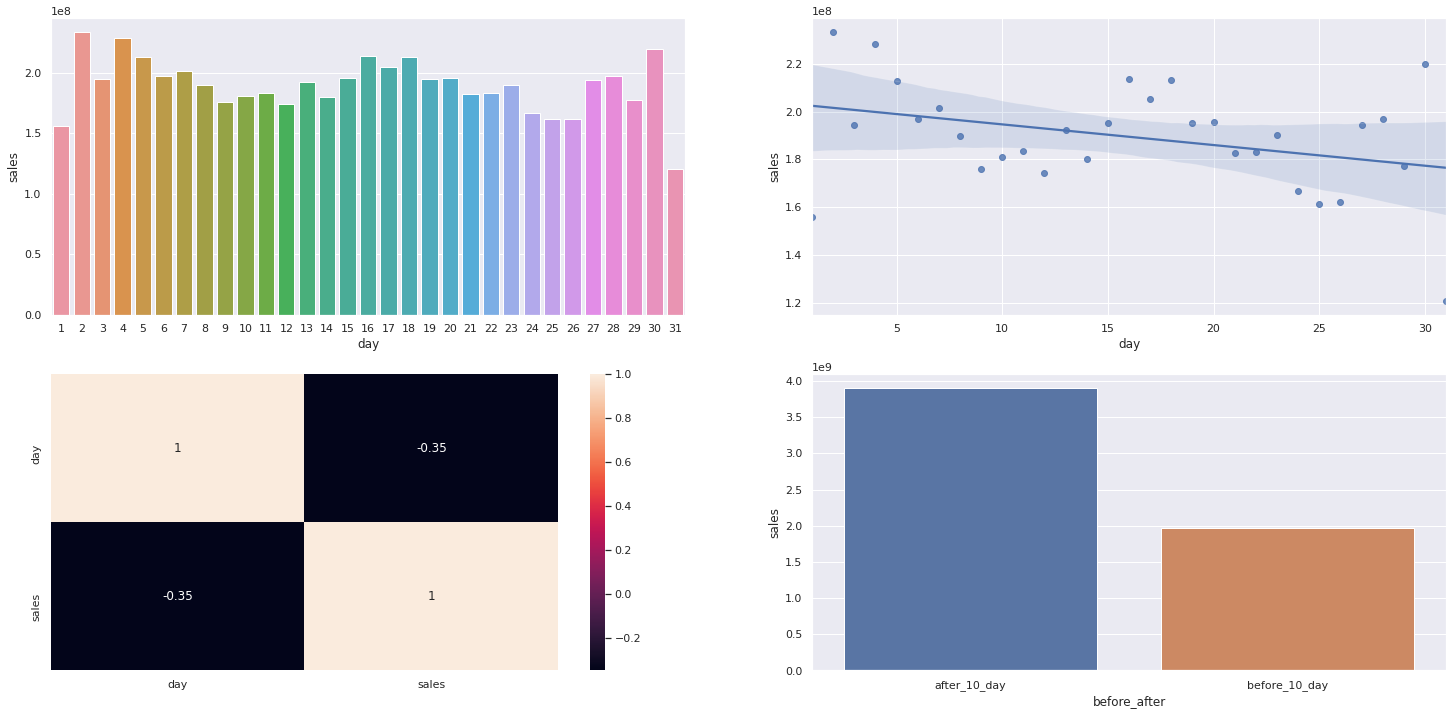

In [ ]:
#@title **Verdadeiro**.
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_day' if x<=10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

#### H11. Lojas deveriam vender menos aos finais de semana.

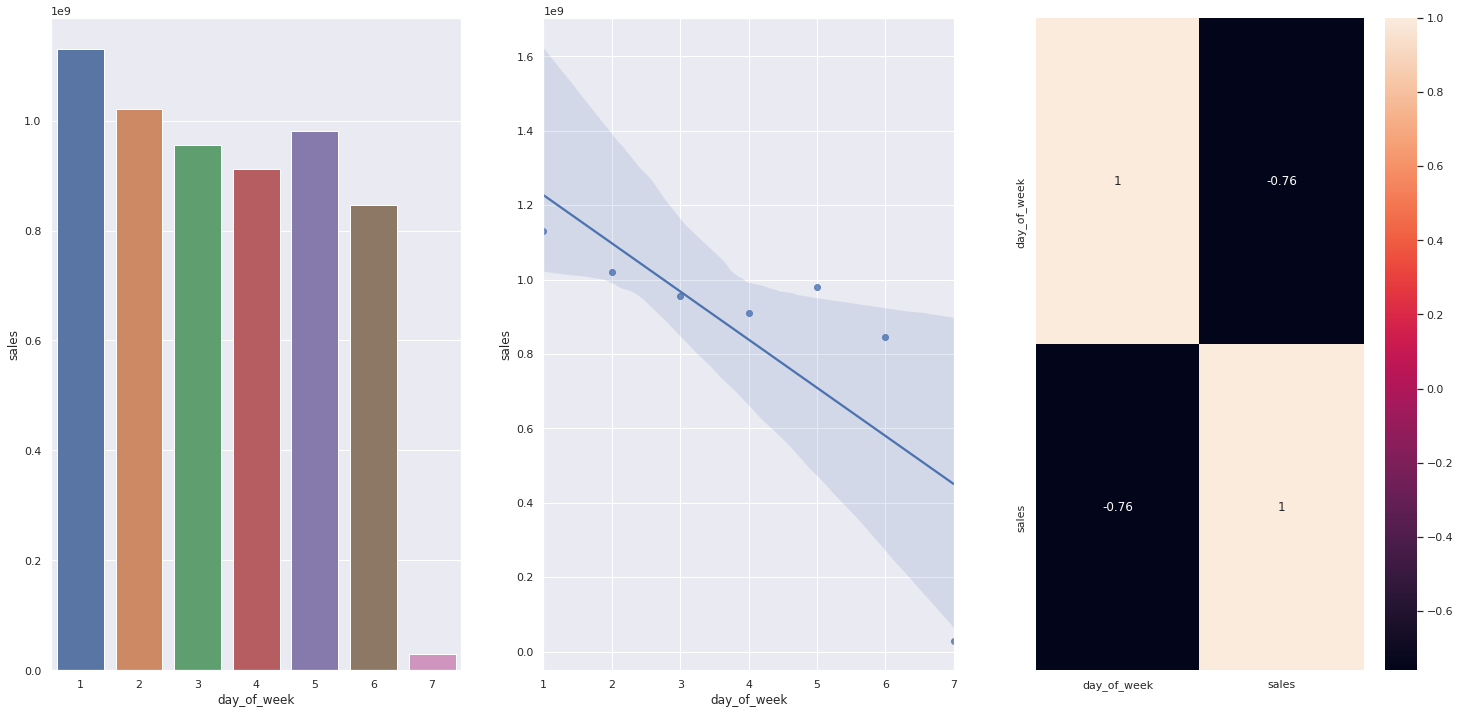

In [ ]:
#@title **Verdadeiro!** Lojas vendem menos nos fds.
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H12. Lojas deveriam vender menos durante os feriados escolares.

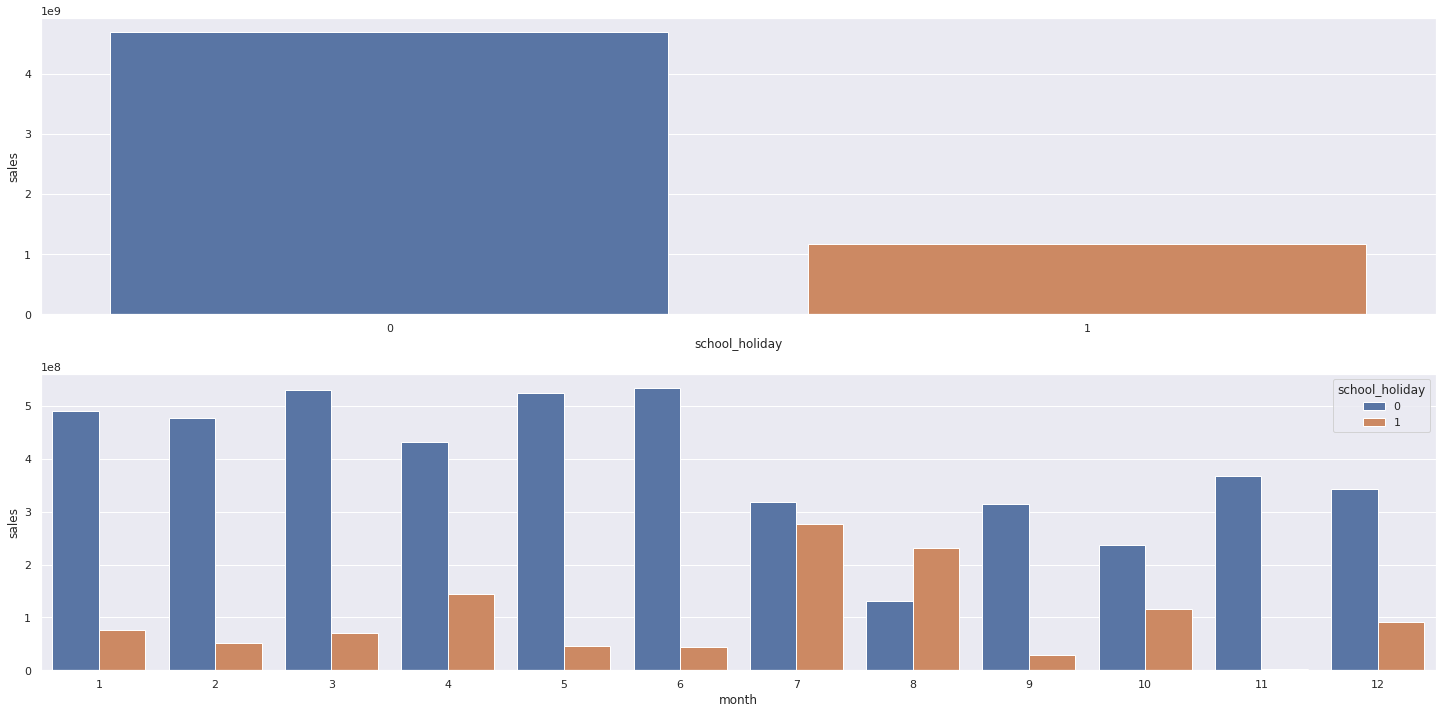

In [ ]:
#@title **Verdadeira!** Lojas vendem menos durante os feriados, exceto no mês de agosto.
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales',data=aux);

aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue = 'school_holiday',data=aux1);

#### 3.2.1 Resumo das Hipóteses

In [ ]:
#@title Tabela resumo
tab = [['Hipóteses','Conclusão','Relevância'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Média'],
       ['H3','Falsa','Média'],
       ['H4','Falsa','Baixa'],
       ['H5','-','-'],
       ['H6','Falsa','Baixa'],
       ['H7','Falsa','Média'],
       ['H8','Falsa','Alta'],
       ['H9','Falsa','Alta'],
       ['H10','Verdadeira','Alta'],
       ['H11','Verdadeira','Alta'],
       ['H12','Verdadeira','Baixa'],
       ]
print(tabulate(tab,headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 3.3. Análise Multivariada

#### 3.3.1 Numerical Attributes

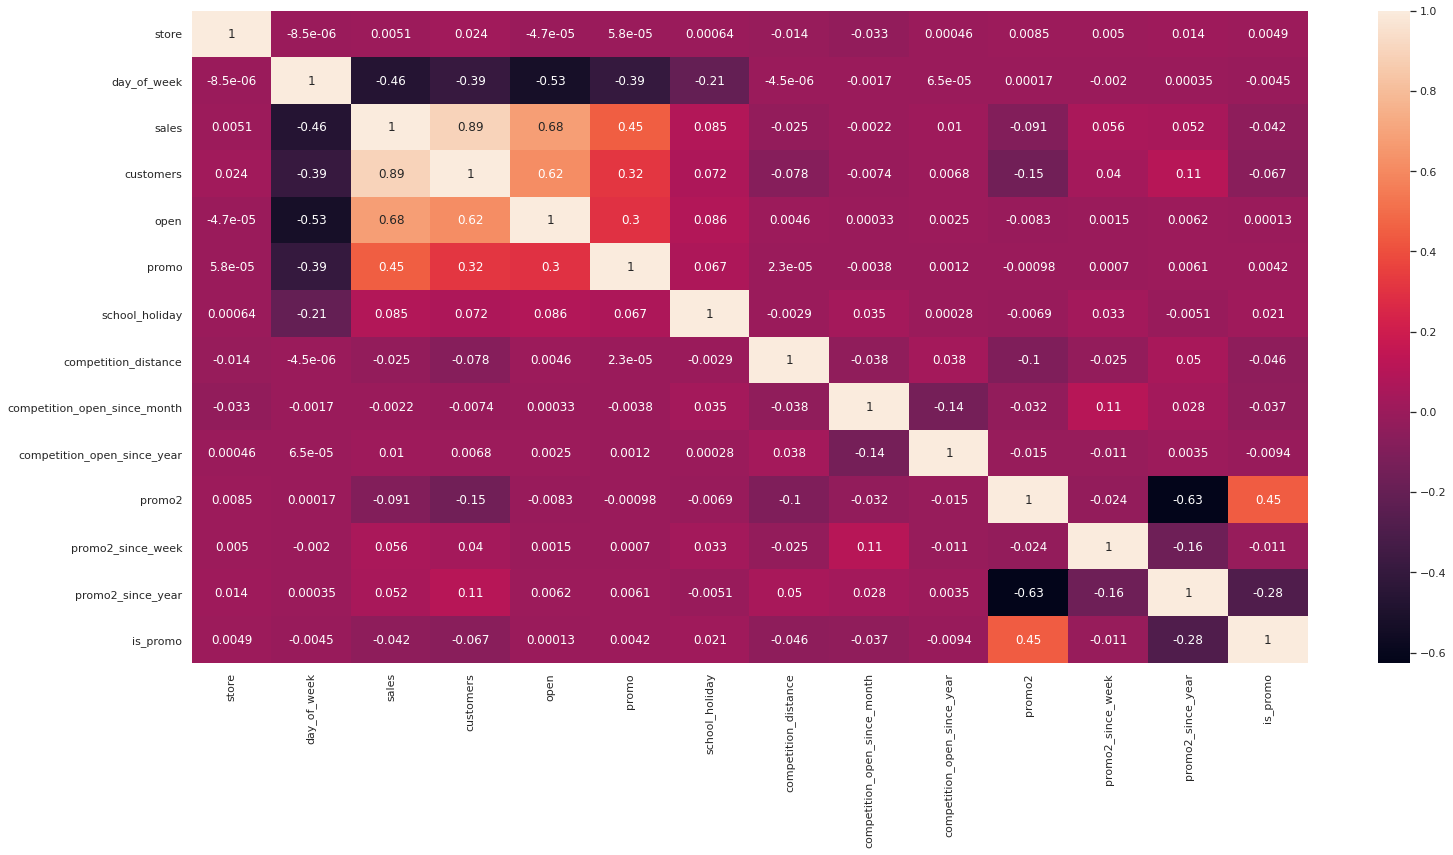

In [ ]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation,annot=True);

#### 3.3.2 Categorical Attributes

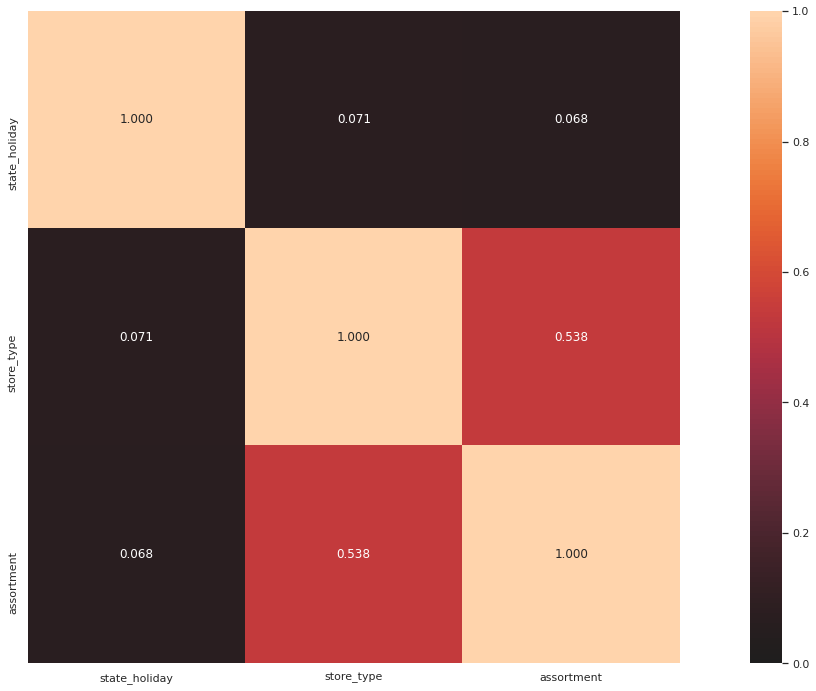

In [ ]:
aux = cat_attributes2.drop(columns = 'year_week')
associations(aux,fmt='.3f');

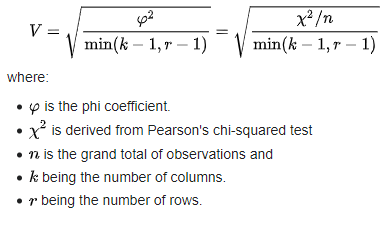

In [ ]:
#@title Deve-se utilizar a correlação Cramer-V, a qual a fórmula é:
Image('Imagens/cramer_v.png')

---
# 4.0 PREPARAÇÃO DOS DADOS

In [ ]:
df5 = df4.copy()

### 4.1 Normalização

In [ ]:
#Nenhuma coluna tem distribuição semelhante à normal
#Interessante utilizar o sklearn.normalizer 

### 4.2 Rescaling

In [ ]:
# - MinMax scaler para distribuições sem muitos outliers
# - Robust scaler para distribuições com muitos outliers
num = df5.select_dtypes(include=['int64','float64','int32','float32'])


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

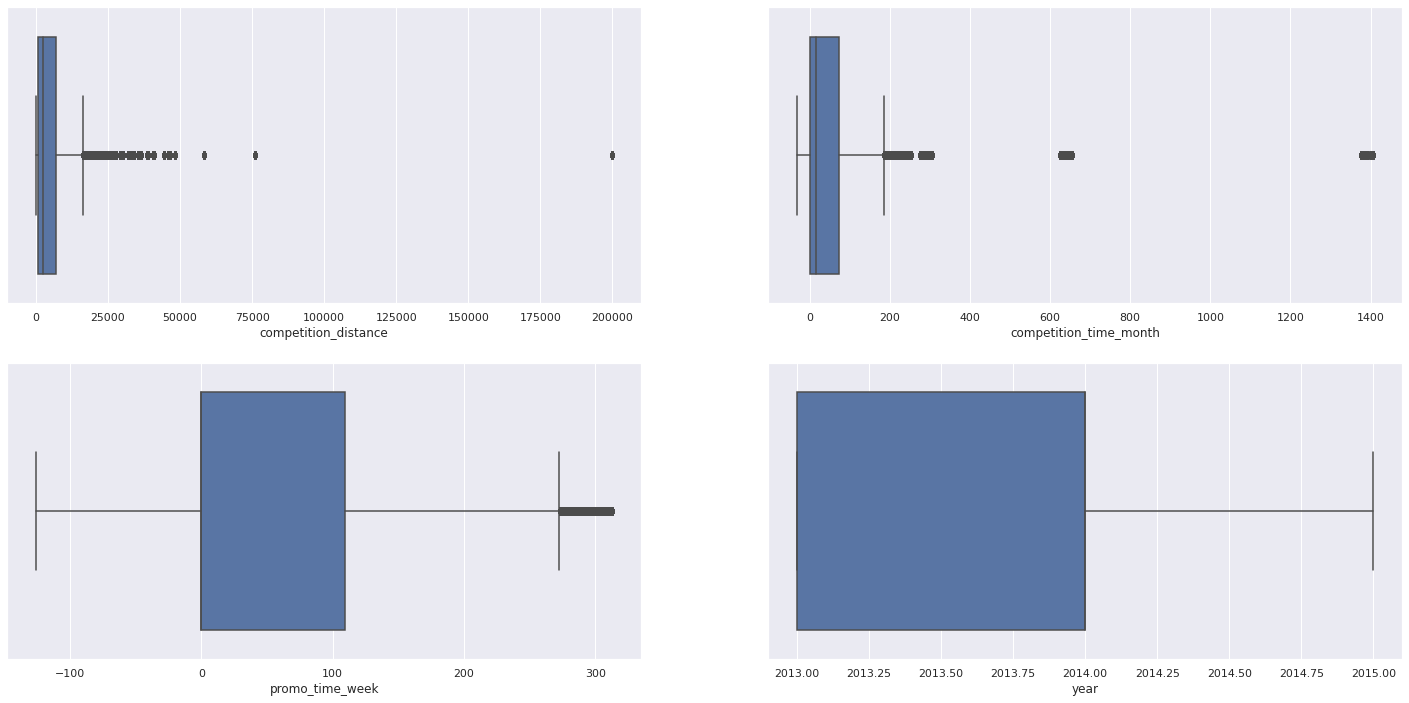

In [ ]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']); #muitos outliers, usar RobustScaler
plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month']); #muitos outliers, usar RobustScaler
plt.subplot(2,2,3) 
sns.boxplot(df5['promo_time_week']); #poucos outliers, usar MinMaxScaler
plt.subplot(2,2,4) 
sns.boxplot(df5['year']); #poucos outliers, usar MinMaxScaler

In [ ]:
rs = RobustScaler()
mm = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/competition_distance_scaler.pkl', 'wb'))

#obs: df[[coluna]] = Dataframe(2d); df[coluna]=Series
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week'] = mm.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mm.fit_transform(df5[['year']].values)
pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/year_scaler.pkl', 'wb'))

### 4.3 Transformação

#### 4.3.1 Encoding

In [ ]:
#state_holiday: one-hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#não precisa do pickles, dá pra fazer direto no código

In [ ]:
#store_type: label encoding
lb=LabelEncoder()
df5['store_type']=lb.fit_transform(df5['store_type'])
pickle.dump(lb, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/store_type_scaler.pkl', 'wb'))

In [ ]:
#assortment: ordinal encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3
                   }
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [ ]:
type(df5[['year']])

pandas.core.frame.DataFrame

#### 4.3.2 Transformação de grandeza da variável de resposta

In [ ]:
#Transformação logarítmica
df5['sales']= np.log1p(df5['sales'])

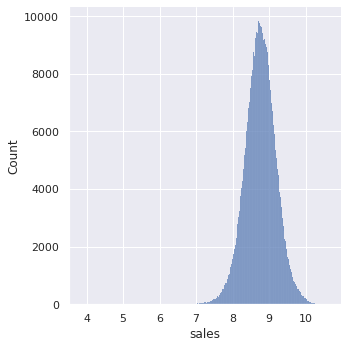

In [ ]:
sns.displot(df5.sales);

#### 4.3.3 Transformação de natureza

In [ ]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
#month - transformação cíclica
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [ ]:
df5.sample()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
323877,652,1,2014-09-29,9.218209,1,0,0,1,2.912903,9,2014,0,40,2014,0,0.5,9,29,40,2014-39,2014-09-01,-0.216216,2014-09-29,0.287016,0,0,0,1,0.781831,0.62349,-1.0,-1.836970e-16,-0.207912,0.978148,-0.992709,0.120537


---
# 5.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()
df6[df6['sales']==0].head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos


In [ ]:
#Dropar variáveis que foram transformadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

### 5.1 Split entre treino e teste - CONSERTAR!!!!! Rescaling antes do split

In [ ]:
#separando o conjunto de teste: 6 semanas finais
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
#2015-06-19 - data que começa as 6 semanas

Timestamp('2015-06-19 00:00:00')

In [ ]:
#training dataset
X_train = df6[df6['date']< '2015-06-19']
y_train = X_train['sales']
X_train = X_train.drop(columns=['sales'])

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Test min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


### 5.2 Boruta como Feature Selector

In [ ]:
'''
X_train_n = X_train.drop(columns=['date']).values
y_train_n = y_train.values.ravel() #ravel coloca em um vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=1).fit(X_train_n, y_train_n)
'''

"\nX_train_n = X_train.drop(columns=['date']).values\ny_train_n = y_train.values.ravel() #ravel coloca em um vetor\n\n#define RandomForestRegressor\nrf = RandomForestRegressor(n_jobs=-1)\n#define boruta\nboruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=1).fit(X_train_n, y_train_n)\n"

### 5.2.1 Melhores Features

In [ ]:
'''
cols_selected = boruta.support_.tolist()
#best features
X_train_fs = X_train.drop(columns=['date'])
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
'''

"\ncols_selected = boruta.support_.tolist()\n#best features\nX_train_fs = X_train.drop(columns=['date'])\ncols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()\n\n#not selected\ncols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))\n"

### 6.3 Feature Selection Manual

In [ ]:
cols_not_selected_boruta= ['is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year'] 


In [ ]:
cols_selected_boruta = ['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos']

 #columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos']

In [ ]:
#Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()

In [ ]:
cols_selected_boruta_full.extend(feat_to_add)

cols_selected_boruta_full

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

---
# 6.0 MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
x_training = df6[df6['date']< '2015-06-19'][cols_selected_boruta_full]

In [ ]:
x_train.head()

NameError: ignored

### 6.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2, how = 'left', on= 'store')
yhat_baseline = aux1['predictions']

#Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) #Sales estava em logarítmo
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 6.2 Linear Regression Model

In [ ]:
#Model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result #Pior que o baseline - indica que o modelo é não linear

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 6.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_cv = TimeSeries_cross_validation(x_training, 5, 'Linear Regression', lr )
lr_cv


Kfold_number: 5
MAE = 2646.810011610891
MAPE = 0.3113730832712245
RMSE = 3821.9010057952573

Kfold_number: 4
MAE = 1908.4710905163834
MAPE = 0.3282525197578609
RMSE = 2576.4577640501834

Kfold_number: 3
MAE = 1803.9807231985142
MAPE = 0.30407757515470285
RMSE = 2522.9104554950104

Kfold_number: 2
MAE = 2069.335137766141
MAPE = 0.28553250427268295
RMSE = 3001.334290370363

Kfold_number: 1
MAE = 1980.0391511732219
MAPE = 0.2838928100139467
RMSE = 2840.000319428181


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 6.3 Linear Regression Regularized Model

In [ ]:
#Model
lasso = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lasso = lasso.predict(x_test)

#performance
lasso_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lasso))
lasso_result #Um pouco pior que a RL comum, o modelo é complexo.

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704415,0.289105,2744.451714


#### 6.3.1 Lasso - Cross Validation

In [ ]:
lasso_cv = TimeSeries_cross_validation(x_training, 5, 'Lasso - CV', lasso)
lasso_cv


Kfold_number: 5
MAE = 2751.45772969123
MAPE = 0.31444700745755
RMSE = 3976.1698822309354

Kfold_number: 4
MAE = 1846.85134014721
MAPE = 0.2911393742797097
RMSE = 2630.90187654536

Kfold_number: 3
MAE = 1808.434156395209
MAPE = 0.28909616304965313
RMSE = 2594.857897302576

Kfold_number: 2
MAE = 2160.6463422004686
MAPE = 0.2846318024391607
RMSE = 3168.024644041631

Kfold_number: 1
MAE = 2014.533600312529
MAPE = 0.2807205269505963
RMSE = 2918.81744864363


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso - CV,2116.38 +/- 341.51,0.29 +/- 0.01,3057.75 +/- 504.27


### 6.4 Random Forest Regressor

In [ ]:
'''
#Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result 
'''


"\n#Model\nrf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train,y_train)\n\n#prediction\nyhat_rf = rf.predict(x_test)\n\n#performance\nrf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))\nrf_result \n"

#### 6.4.1 RandomForest Cross Validation

In [ ]:
'''
rf_cv = TimeSeries_cross_validation(x_training, 5, 'RandomForest - CV', rf)
rf_cv

'''

"\nrf_cv = TimeSeries_cross_validation(x_training, 5, 'RandomForest - CV', rf)\nrf_cv\n\n"

### 6.5 XGBoost Regressor

In [ ]:
'''
#Model
xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, eta = 0.01, max_depth = 10,
                       subsample=0.7, colsample_bytree=0.9, n_jobs=-1, random_state=1).fit(x_train,y_train)

#prediction
yhat_xgb = xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result  

'''

"\n#Model\nxgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, eta = 0.01, max_depth = 10,\n                       subsample=0.7, colsample_bytree=0.9, n_jobs=-1, random_state=1).fit(x_train,y_train)\n\n#prediction\nyhat_xgb = xgb.predict(x_test)\n\n#performance\nxgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))\nxgb_result  \n\n"

#### 6.5.1 XGBoost Cross Validation

In [ ]:
'''
xgb_cv = TimeSeries_cross_validation(x_training, 5, 'XGBoost - CV', xgb)
xgb_cv
'''

"\nxgb_cv = TimeSeries_cross_validation(x_training, 5, 'XGBoost - CV', xgb)\nxgb_cv\n"

### 6.6 Comparação das performances dos modelos

In [ ]:
#modelling_result = pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv])
#modelling_result.sort_values('RMSE CV') 

In [ ]:

modelling_result = pd.DataFrame(data = [['RandomForest - CV','842.51 +/- 218.07',	'0.12 +/- 0.02',	'1264.95 +/- 314.52'],['XGBoost - CV','1032.31 +/- 140.3',	'0.14 +/- 0.01',	'1484.16 +/- 193.7'],
                                        ['Linear Regression',	'2081.61 +/- 295.99',	'0.28 +/- 0.02',	'2953.18 +/- 468.58'],['Lasso - CV' ,'2116.8 +/- 341.61',	'0.29 +/- 0.02',	'3058.77 +/- 504.1']],
                                        columns= ['Model Name',	'MAE CV',	'SMAPE CV',	'RMSE CV'])


In [ ]:
modelling_result

,Model Name,MAE CV,SMAPE CV,RMSE CV
0,RandomForest - CV,842.51 +/- 218.07,0.12 +/- 0.02,1264.95 +/- 314.52
1,XGBoost - CV,1032.31 +/- 140.3,0.14 +/- 0.01,1484.16 +/- 193.7
2,Linear Regression,2081.61 +/- 295.99,0.28 +/- 0.02,2953.18 +/- 468.58
3,Lasso - CV,2116.8 +/- 341.61,0.29 +/- 0.02,3058.77 +/- 504.1


---
# 7.0 HYPERPARAMETER FINE TUNING

### 7.1 Random Search

In [ ]:
'''
param = {
    'n_estimators': [1500, 2000, 2500, 3000, 3500],
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15] }
MAX_EVAL = 5 #Quantas interações haverão

'''

"\nparam = {\n    'n_estimators': [1500, 2000, 2500, 3000, 3500],\n    'eta': [0.01, 0.03, 0.05],\n    'max_depth': [3, 5, 9],\n    'subsample': [0.1, 0.5, 0.7],\n    'colsample_bytree': [0.3, 0.7, 0.9],\n    'min_child_weight': [3, 8, 15] }\nMAX_EVAL = 5 #Quantas interações haverão\n\n"

In [ ]:
'''
#Será utilizado o XGBoost
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
  #Escolher parâmetros aleatoriamente
  hp = {k: random.sample(v,1)[0] for k, v in param.items()}
  print(hp)
#Model
  model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'],
                        subsample=hp['subsample'], colsample_bytree=hp['colsample_bytree'], min_child_weight=hp['min_child_weight'], random_state=1).fit(x_train,y_train)

  #performance
  xgb_result = TimeSeries_cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose = False)
  final_result = pd.concat([final_result, result])

'''

"\n#Será utilizado o XGBoost\nfinal_result = pd.DataFrame()\nfor i in range(MAX_EVAL):\n  #Escolher parâmetros aleatoriamente\n  hp = {k: random.sample(v,1)[0] for k, v in param.items()}\n  print(hp)\n#Model\n  model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'],\n                        subsample=hp['subsample'], colsample_bytree=hp['colsample_bytree'], min_child_weight=hp['min_child_weight'], random_state=1).fit(x_train,y_train)\n\n  #performance\n  xgb_result = TimeSeries_cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose = False)\n  final_result = pd.concat([final_result, result])\n\n"

### 7.2 Final Model

In [ ]:
param_tuned = {
    'n_estimators': 3000 ,
    'eta': 0.03 ,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3}

In [ ]:
#Model
#model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=param_tuned['n_estimators'],
 #                            eta = param_tuned['eta'], max_depth = param_tuned['max_depth'],
  #                           subsample=param_tuned['subsample'], colsample_bytree=param_tuned['colsample_bytree'],
   #                          min_child_weight=param_tuned['min_child_weight'], random_state=1).fit(x_train,y_train)

#Salvando o modelo
#pickle.dump(model_xgb_tuned, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/model_xgb_tuned.pkl','wb'))


In [ ]:
#Relendo o modelo
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/model_xgb_tuned.pkl','rb'))


In [ ]:
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned =ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.676548,0.097647,952.289102


---
# 8.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_test[cols_selected_boruta_full]
#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 8.1 Business Performance

In [ ]:
#sum of predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on = 'store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on = 'store')
df9_2.head()

#Cenários
df9_2['worst_scenario'] = df9_2['predictions']-df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions']+df9_2['MAE']

#ordenando as colunas
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario','MAE','MAPE']]
df9_2.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,160576.812500,160305.102697,160848.522303,271.709803,0.062196
1,2,170876.609375,170475.602684,171277.616066,401.006691,0.080864
2,3,262515.156250,261945.575367,263084.737133,569.580883,0.081822
3,4,339543.062500,338602.317040,340483.807960,940.745460,0.090048
4,5,167352.015625,167033.940562,167670.090688,318.075063,0.070703


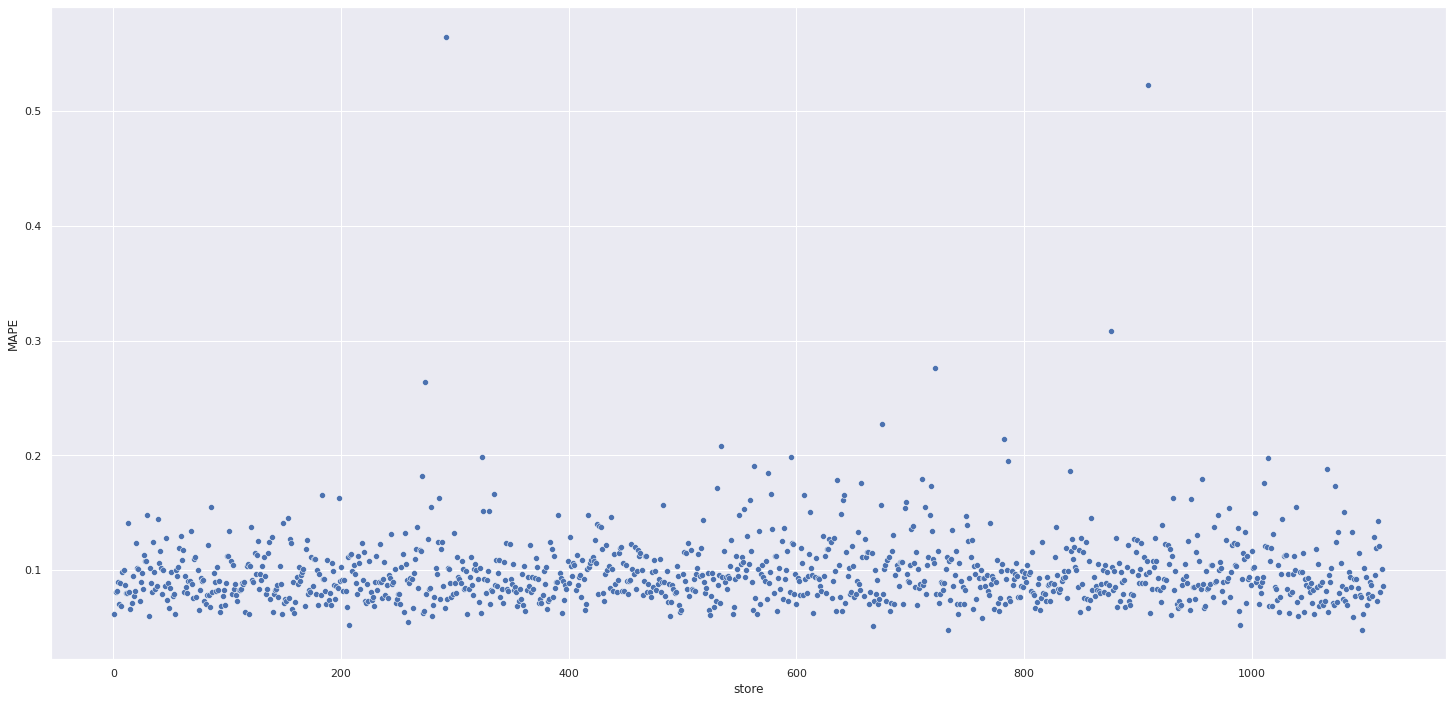

In [ ]:
sns.scatterplot(x='store', y='MAPE', data = df9_2)

### 8.2 Total Performance

In [ ]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values' })
df9_3['Values'] = df9_3['Values'].map('R${:,.2f}'.format)
df9_3

,Scenario,Values
0,predictions,"R$286,738,496.00"
1,worst_scenario,"R$285,998,954.73"
2,best_scenario,"R$287,478,045.33"


### 8.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Dispersão dos erros')

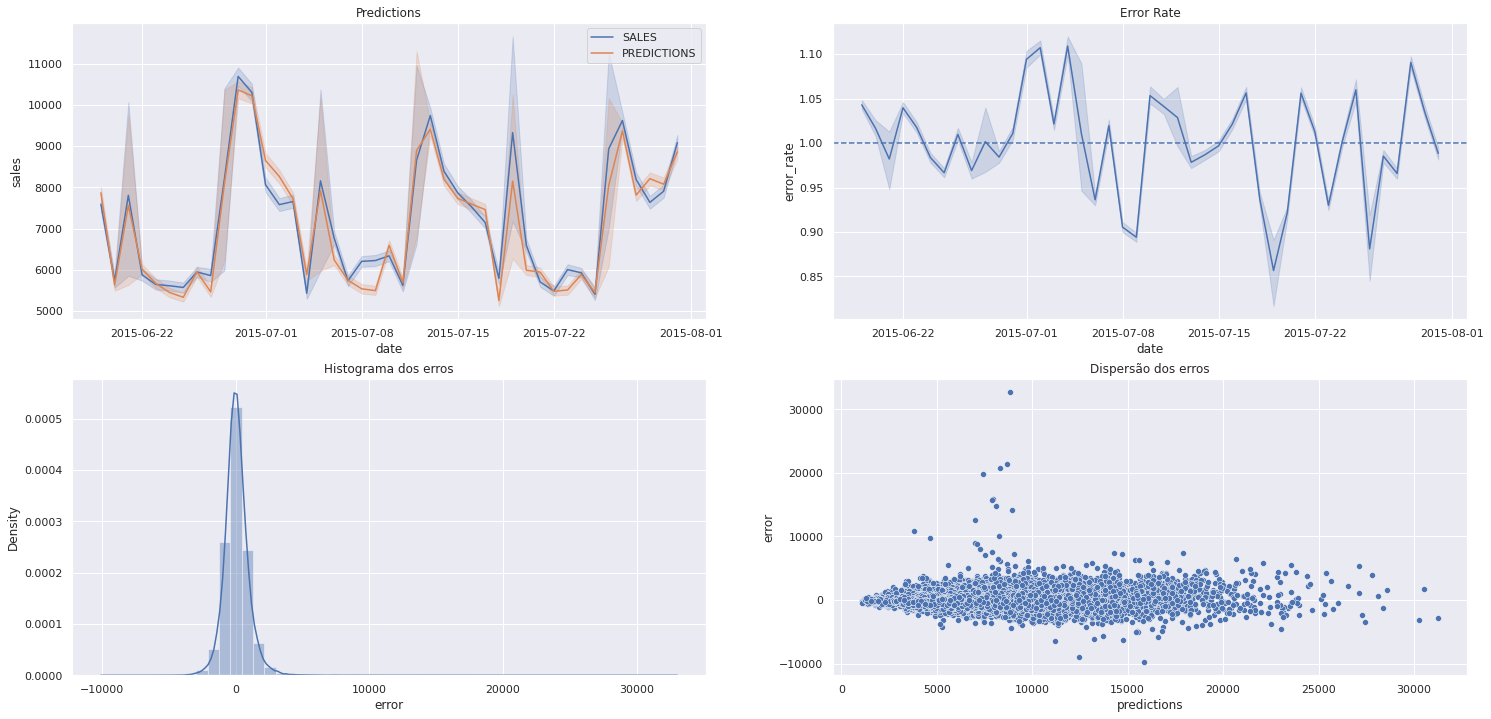

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y='sales', data=df9, label='SALES')
sns.lineplot(x = 'date', y='predictions', data=df9, label='PREDICTIONS')
plt.title('Predictions')


plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.title('Error Rate')
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])
plt.title('Histograma dos erros')

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Dispersão dos erros')

# 9.0 DEPLOY DO MODELO EM PRODUÇÃO

In [ ]:
#Usar o pickle para armazenar o modelo_xgb, o Rescaling das colunas, o tratamento dos dados em geral

### 9.1 Rossman Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import json

class Rossmann (object):
  def __init__(self):
    self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
    self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
    self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
    self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
    self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
  
  def data_cleaning(self, df1):
    # 1.1. Rename Columns
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open','Promo', 'StateHoliday', 'SchoolHoliday', 
                'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
                'CompetitionOpenSinceYear','Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

    #Usando snakecase da biblioteca inflection:
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase,cols_old))

    #Renomeando: 
    df1.columns = cols_new

    #Transformando a coluna date para o tipo datetime:
    df1['date'] = pd.to_datetime(df1['date'])

    ### 1.5. Fillout NA

    #competition_distance
    df1['competition_distance'] = df1.competition_distance.apply(lambda x: 200000 if math.isnan(x) else x)

    #competition_open_since_month : 
    df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

    #competition_open_since_year     
    df1.competition_open_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year , axis = 1)
                                  
    #promo2_since_week            
    df1.promo2_since_week = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis = 1)

    #promo2_since_year    
    df1.promo2_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis = 1)

    #promo_interval: se não participar da promoção, colocar 0. Se participar, criar uma nova coluna indicando se está tendo uma promoção na data da linha   
    months_dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11:'Nov', 12: 'Dec'}

    df1.promo_interval.fillna(0, inplace = True)

    df1['month_map'] = df1.date.dt.month.map(months_dic)

    df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x.promo_interval == 0 else 1 if x.month_map in x.promo_interval.split(',') else 0,axis = 1)

    ### 1.6. Change Types
    df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
    df1.competition_open_since_year = df1.competition_open_since_year.astype(int)

    df1.promo2_since_week = df1.promo2_since_week.astype(int)
    df1.promo2_since_year = df1.promo2_since_year.astype(int)

    return df1

  def feature_engineering(self, df2):

    # year
    df2['year'] = df2.date.dt.year
    #month
    df2['month'] = df2.date.dt.month
    #day
    df2['day'] = df2.date.dt.day
    #week of year
    df2['week_of_year'] = df2.date.dt.weekofyear
    #year week
    df2['year_week'] = df2.date.dt.strftime('%Y-%W')
    #competition since - tempo desde que a competição começou - Está separada em 2 colunas, precisamos uni-las
    df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis = 1)
    df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

    #promo since - tempo desde que a promoção começou
    df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
    df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    df2['promo_time_week'] = ((df2.date - df2.promo_since)/7).apply(lambda x: x.days).astype(int)
    #assortment
    df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

    #state holiday
    df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

    # 2.5.1. Filtragem das Linhas
    df2 = df2[df2['open'] !=0]
    
    # 2.5.2. Seleção das colunas
    cols_drop=['open', 'promo_interval', 'month_map']
    df2 = df2.drop(cols_drop, axis=1)

    return df2

  def data_preparation(self,df5):
    ### 4.2 Rescaling
    #competition distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

    #competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
   
    #promo time week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
    
    #year
    df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

    # 4.3.1 Encoding
    #state_holiday: one-hot encoding
    df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

    #store_type: label encoding
    df5['store_type']=self.store_type_scaler.fit_transform(df5['store_type'])

    #assortment: ordinal encoding
    assortment_dict = {'basic': 1,
                      'extra': 2,
                      'extended': 3
                      }
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    # 4.3.3 Transformação de natureza
    #day of week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

    #month - transformação cíclica
    df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
    df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

    #day
    df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
    df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

    #week of year
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

    cols_selected = ['assortment',  'competition_distance',  'competition_open_since_month',  'competition_open_since_year',
    'competition_time_month',  'day_sin',  'day_cos',  'day_of_week_cos',  'day_of_week_sin',  'month_sin',  'month_cos',  'promo',
    'promo2',  'promo2_since_week',  'promo2_since_year',  'promo_time_week',  'store',  'store_type',  'week_of_year_sin',
    'week_of_year_cos']


    return df5[cols_selected]

  def get_prediction(self,model, original_data, test_data):
    #prediction
    pred = model.predict(test_data)
    #join pred into the original data
    original_data['prediction'] = np.expm1(pred)

    return original_data.to_json(orient='records', date_format='iso')


### 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('model/model_xgb_tuned.pkl','rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
  test_json = request.get_json()
  
  if test_json: #there is data

    if isinstance(test_json, dict): #unique example
      test_raw = pd.DataFrame(test_json, index=[0])

    else: #multiple examples
      test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    #intanciar a rossmann class
    pipeline = Rossmann()
    
    #data cleaning
    df1 = pipeline.data_cleaning(test_raw)

    #feature engineering
    df2 = pipeline.feature_engineering(df1)

    #data preparation
    df3 = pipeline.data_preparation(df2)

    #prediction
    df_response = pipeline.get_prediction(model, test_raw, df3)

    return df_response

  else:
    return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
  port = os.environ.get('PORT',5000)
  app.run(host = '0.0.0.0', port = port)


### 9.3 Criando os arquivos

In [ ]:
#Criando pasta API - Usando o GIT !
#!mkdir -p api/rossman

In [ ]:
#cd /content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/api

In [ ]:
#!touch handler.py

In [ ]:
#cd rossmann

In [ ]:
#!touch Rossman.py

In [ ]:
#Editar os arquivos .py e colar os códigos dos snippets respectivos. 
#Executar !python handler.py em outro colab notebook
#copiar o endereço ngrok
#colar no API Tester

### 9.4 API Tester

In [ ]:
import requests

In [ ]:
df10 = pd.read_csv('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Dados/test.csv')

In [ ]:
#merge test df10 + store
df_test = pd.merge(df10,df_store_raw, how = 'left', on='Store')

#choose store 
df_test = df_test[df_test['Store'].isin([24,12,22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop(columns='Id')

In [ ]:
import json
#convert Df to JSON
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
#API call
url = 'https://rossmann-test1.herokuapp.com/rossmann/predict'
#url = 'http://78f7b96dbbe8.ngrok.io/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers = header)
print('Status Code{}'.format(r.status_code))

Status Code200


In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5794.692383
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3805.298340
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,7980.909180
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5929.270996
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3883.766602


In [ ]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
  print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(
      d2.loc[i,'store'], d2.loc[i, 'prediction']
  ))

Store number 12 will sell R$223,701.60 in the next 6 weeks
Store number 22 will sell R$139,371.96 in the next 6 weeks
Store number 24 will sell R$292,147.63 in the next 6 weeks


In [ ]:
d2

,store,prediction
0,12,223701.597168
1,22,139371.962524
2,24,292147.634766


### 9.5 Deploy no Heroku

#### No Colab:
- Criar uma pasta webapp, com as subpastas model, parameter, rossmann.
- Copiar modelo, parametros e handler para as pastas recém criadas.
- Criar arquivo Procfile: !touch Procfile
- pip freeze > requirements.txt (deixar apenas o que realmente usa)
- editar os arquivos handle, Rossmann e Procfile
- Dar o git push para salvar no github

#### No pc:
- Dar o git clone na pasta repos
- Instalar o Heroku CLI
- Abrir o Git Bash
- Entrar na pasta webapp pelo terminal
- git init
- heroku login
- git status
- git add .
- git commit -m 'initial commit'
- heroku apps:create nome-do-app
- git push heroku master
- Testar o modelo



In [ ]:
cd rossmann-telegram-api/

[Errno 2] No such file or directory: 'rossmann-telegram-api/'
/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/rossmann-telegram-api


In [ ]:
!touch rossman-bot.py

In [ ]:
!python rossmann-bot.py

Status Code200
Store number 22 will sell R$144,083.99 in the next 6 weeks


In [ ]:
ls -l

total 2
-rw------- 1 root root 1035 Oct 26 18:03 rossman-bot.py
